Rating Range: 1.0 to 5.0
Total Number of Users (tnu): 50
Total Number of Items (tni): 99
Number of Ratings per Product:
 productId
I54    12
I71    11
I25    11
I8     10
I22    10
Name: count, dtype: int64
Active Users: U35=U35, U7=U7, U10=U10
Target Items: I1=I2, I2=I54
Co-ratings for U35: (28, 5)
Co-ratings for U7: (43, 13)
Co-ratings for U10: (31, 9)
Top Common Users (Descending Order): [[4, 'U27'], [4, 'U31'], [4, 'U40'], [4, 'U47'], [4, 'U41']]


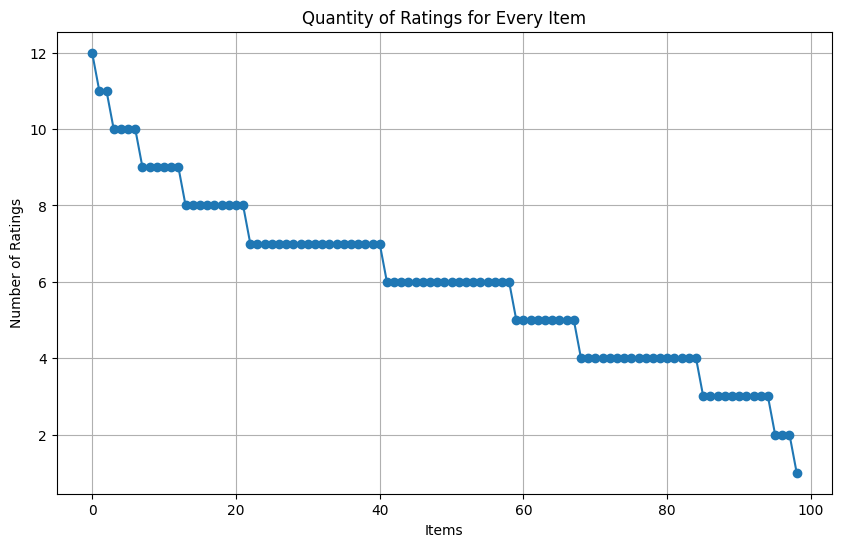

Threshold β for U35: 4
Threshold β for U7: 6
Threshold β for U10: 7


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Step 1: Remove rows with missing or zero ratings
df = df.dropna(subset=['rating'])  # Drop rows with missing ratings
df = df[df['rating'] != 0]        # Drop rows with zero ratings

# Step 2: Adjust the ratings to a 1-to-5 scale.
# Assuming ratings are already on a 1-to-5 scale, verify the range.
print("Rating Range:", df['rating'].min(), "to", df['rating'].max())

# Step 3: Count total number of users and items.
tnu = df['userId'].nunique()
tni = df['productId'].nunique()
print(f"Total Number of Users (tnu): {tnu}")
print(f"Total Number of Items (tni): {tni}")

# Step 4: Count the number of ratings for every product.
ratings_per_product = df['productId'].value_counts()
print("Number of Ratings per Product:\n", ratings_per_product.head())

# Step 5: Define active users (with better thresholds).
active_users = ['U35', 'U7', 'U10']
U35, U7, U10 = active_users
print(f"Active Users: U35={U35}, U7={U7}, U10={U10}")

# Step 6: Pick two target items with specified missing ratings.
target_items = df['productId'].unique()[:2]  # Select first 2 unique items as I1, I2.
I1, I2 = target_items
print(f"Target Items: I1={I1}, I2={I2}")

# Step 7: Count co-ratings.
def co_ratings(user, df):
    user_items = set(df[df['userId'] == user]['productId'])
    other_users = df[df['productId'].isin(user_items)]['userId'].nunique()
    return other_users, len(user_items)

co_ratings_U35 = co_ratings(U35, df)
co_ratings_U7 = co_ratings(U7, df)
co_ratings_U10 = co_ratings(U10, df)

print(f"Co-ratings for U35: {co_ratings_U35}")
print(f"Co-ratings for U7: {co_ratings_U7}")
print(f"Co-ratings for U10: {co_ratings_U10}")

# Step 8: Create 2-D array with "No_common_users" in descending order.
common_users = []
for user in [U35, U7, U10]:
    user_items = set(df[df['userId'] == user]['productId'])
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_count = len(user_items & other_user_items)
            common_users.append([common_count, other_user])

common_users = sorted(common_users, key=lambda x: x[0], reverse=True)
print("Top Common Users (Descending Order):", common_users[:5])

# Step 9: Draw a curve illustrating quantity of ratings for every item.
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_product.values, marker='o')
plt.title("Quantity of Ratings for Every Item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.grid()
plt.show()

# Step 10: Determine threshold β for co-rated items.
def calculate_threshold(user, df, percentage):
    user_items = set(df[df['userId'] == user]['productId'])
    thresholds = []
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_items = len(user_items & other_user_items)
            if len(user_items) > 0 and common_items / len(user_items) >= percentage:
                thresholds.append(other_user)
    return len(thresholds)

threshold_U35 = calculate_threshold(U35, df, 0.3)
threshold_U7 = calculate_threshold(U7, df, 0.3)
threshold_U10 = calculate_threshold(U10, df, 0.3)

print(f"Threshold β for U35: {threshold_U35}")
print(f"Threshold β for U7: {threshold_U7}")
print(f"Threshold β for U10: {threshold_U10}")

# Step 11: Save results.
results = {
    "Total Users": tnu,
    "Total Items": tni,
    "Ratings Per Product": ratings_per_product,
    "Active Users": [U35, U7, U10],
    "Target Items": [I1, I2],
    "Co-Ratings": {
        U35: co_ratings_U35,
        U7: co_ratings_U7,
        U10: co_ratings_U10
    },
    "Thresholds": {
        U35: threshold_U35,
        U7: threshold_U7,
        U10: threshold_U10
    }
}


In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# Display the first few rows of the cleaned dataset
print("Dataset Overview (Cleaned):")
display(df_cleaned.head())

# Verify rating range
print(f"Rating Range: {df_cleaned['rating'].min()} to {df_cleaned['rating'].max()}")

# Total users and items
total_users = df_cleaned['userId'].nunique()
total_items = df_cleaned['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating').fillna(0)

# --- Step 1.1.1: Compute Cosine Similarity ---
# Cosine similarity without bias adjustment
cosine_sim_matrix = cosine_similarity(user_item_matrix)

# Convert similarity matrix to DataFrame for better handling
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)
print("Cosine Similarity Matrix:")
display(cosine_sim_df.head())

# --- Step 1.1.2: Top 20% Closest Users ---
def get_top_closest_users(active_user, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest users to an active user."""
    user_similarities = similarity_matrix[active_user].drop(active_user)  # Drop the active user
    top_n = int(len(user_similarities) * top_percent)
    return user_similarities.nlargest(top_n)

# Select new active users
active_users = ['U35', 'U7', 'U10']
print(f"Active Users: {active_users}")

# Get top closest users for each active user
top_users = {}
for user in active_users:
    top_users[user] = get_top_closest_users(user, cosine_sim_df)
    print(f"Top Closest Users for {user}:")
    display(top_users[user])

# --- Step 1.1.3: Predict Ratings (No Bias Adjustment) ---
def predict_ratings(active_user, top_users, user_item_matrix):
    """Predict ratings for items not yet seen by active user."""
    unseen_items = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user] == 0].index
    predictions = {}
    
    for item in unseen_items:
        numerator = 0
        denominator = 0
        for user, sim in top_users.items():
            rating = user_item_matrix.loc[user, item]
            numerator += sim * rating
            denominator += abs(sim)
        
        predictions[item] = numerator / denominator if denominator != 0 else 0
        
    return predictions

# Predictions for active users
predictions = {}
for user in active_users:
    predictions[user] = predict_ratings(user, top_users[user], user_item_matrix)
    print(f"Predicted Ratings for {user}:")
    display(predictions[user])

# --- Step 1.1.4: Compute Discount Factor and Discounted Similarity ---
def compute_discounted_similarity(active_user, similarity_matrix, beta):
    """Apply discount factor to similarity."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    df = user_similarities.apply(lambda x: x / (1 + beta))
    return df

# Threshold β for active users
threshold_beta = {user: 2 for user in active_users}  # Example threshold

discounted_sim = {}
for user in active_users:
    discounted_sim[user] = compute_discounted_similarity(user, cosine_sim_df, threshold_beta[user])
    print(f"Discounted Similarity for {user}:")
    display(discounted_sim[user])

# --- Step 1.1.5: Top 20% Closest Users (Discounted Similarity) ---
discounted_top_users = {}
for user in active_users:
    discounted_top_users[user] = discounted_sim[user].nlargest(int(len(discounted_sim[user]) * 0.2))
    print(f"Top Discounted Users for {user}:")
    display(discounted_top_users[user])

# --- Step 1.1.6: Predict Ratings (Discounted Similarity) ---
discounted_predictions = {}
for user in active_users:
    discounted_predictions[user] = predict_ratings(user, discounted_top_users[user], user_item_matrix)
    print(f"Predicted Ratings with Discounted Similarity for {user}:")
    display(discounted_predictions[user])

# --- Step 1.1.7: Compare Results ---
print("Comparison of Top Closest Users (Original vs Discounted):")
for user in active_users:
    original = set(top_users[user].index)
    discounted = set(discounted_top_users[user].index)
    overlap = original & discounted
    print(f"User {user} - Overlap: {len(overlap)} / {len(original)}")

# --- Step 1.1.8: Compare Predictions ---
print("Comparison of Predictions (Original vs Discounted):")
for user in active_users:
    original_preds = predictions[user]
    discounted_preds = discounted_predictions[user]
    print(f"Predictions for {user}:")
    for item in original_preds.keys():
        print(f"Item {item}: Original={original_preds[item]:.2f}, Discounted={discounted_preds[item]:.2f}")


Dataset Overview (Cleaned):


,userId,productId,rating
0,U1,I13,3.0
1,U1,I18,NaN
2,U1,I20,2.0
3,U1,I24,3.0
4,U1,I27,5.0


Rating Range: 1.0 to 5.0
Total Number of Users: 50
Total Number of Items: 100
Cosine Similarity Matrix:


userId,U1,U10,U11,U12,U13,U14,U15,U16,U17,U18,...,U46,U47,U48,U49,U5,U50,U6,U7,U8,U9
userId,,,,,,,,,,,,,,,,,,,,,
U1,1.000000,0.000000,0.085126,0.219265,0.021757,0.186418,0.085122,0.061069,0.138598,0.000000,...,0.020716,0.181086,0.000000,0.070563,0.025555,0.064246,0.122952,0.263743,0.042258,0.124815
U10,0.000000,1.000000,0.225583,0.000000,0.000000,0.000000,0.038868,0.000000,0.139862,0.000000,...,0.000000,0.137997,0.137341,0.081445,0.000000,0.000000,0.063861,0.071162,0.143338,0.222270
U11,0.085126,0.225583,1.000000,0.231446,0.103718,0.058465,0.031214,0.054585,0.013214,0.194197,...,0.090523,0.209978,0.140932,0.140156,0.000000,0.076565,0.212467,0.085723,0.007194,0.193374
U12,0.219265,0.000000,0.231446,1.000000,0.097957,0.120473,0.080400,0.099980,0.245062,0.000000,...,0.000000,0.018029,0.119951,0.115524,0.047068,0.026295,0.135873,0.132482,0.000000,0.076629
U13,0.021757,0.000000,0.103718,0.097957,1.000000,0.348671,0.000000,0.079574,0.000000,0.000000,...,0.157052,0.000000,0.021926,0.111449,0.000000,0.273972,0.000000,0.272659,0.085812,0.088711


Active Users: ['U35', 'U7', 'U10']
Top Closest Users for U35:


userId
U47    0.274218
U31    0.263493
U21    0.245935
U26    0.213850
U50    0.193528
U15    0.177518
U43    0.165145
U10    0.164214
U37    0.154823
Name: U35, dtype: float64

Top Closest Users for U7:


userId
U40    0.299809
U13    0.272659
U1     0.263743
U6     0.245566
U9     0.241955
U44    0.235018
U50    0.226437
U27    0.219995
U41    0.211268
Name: U7, dtype: float64

Top Closest Users for U10:


userId
U21    0.363474
U43    0.282490
U38    0.268576
U39    0.232700
U11    0.225583
U9     0.222270
U24    0.205793
U3     0.184187
U35    0.164214
Name: U10, dtype: float64

Predicted Ratings for U35:


{'I10': 0.11542454945486283,
 'I100': 0.8701191349469953,
 'I11': 0.3565445122925714,
 'I12': 0.0,
 'I13': 0.2874437620296508,
 'I14': 0.47907293671608464,
 'I15': 0.0,
 'I16': 0.6212924670230711,
 'I17': 0.0,
 'I18': 0.2506946646981322,
 'I2': 1.045356148294737,
 'I20': 0.09581458734321692,
 'I21': 0.3832583493728677,
 'I22': 0.0,
 'I23': 0.5688772762911154,
 'I24': 0.4178244411635536,
 'I25': 1.0511450190912028,
 'I27': 0.5600437602363325,
 'I28': 0.5771227472743141,
 'I29': 0.0,
 'I3': 0.6644998705272208,
 'I30': 0.39822683686645916,
 'I31': 0.0,
 'I32': 0.7091564808147898,
 'I33': 0.6094536158499875,
 'I34': 0.0,
 'I35': 0.0,
 'I36': 0.0,
 'I37': 0.0,
 'I38': 0.19162917468643384,
 'I39': 0.0,
 'I4': 0.0,
 'I40': 0.6644998705272208,
 'I41': 0.7110965953638941,
 'I42': 0.08356488823271073,
 'I43': 0.4178244411635536,
 'I44': 0.0,
 'I45': 0.8706825268260705,
 'I46': 0.0,
 'I47': 0.5236742887579928,
 'I48': 0.7400409493462232,
 'I49': 0.0,
 'I5': 0.21630716718819712,
 'I50': 0.51529190

Predicted Ratings for U7:


{'I1': 0.0,
 'I10': 0.49627792301594853,
 'I100': 0.4431697735867288,
 'I11': 0.0,
 'I12': 0.3323773301900466,
 'I13': 0.6828815846334463,
 'I14': 0.0,
 'I15': 0.0,
 'I16': 0.0,
 'I17': 0.0,
 'I18': 0.4431697735867288,
 'I19': 0.0,
 'I2': 0.5410614790205344,
 'I20': 0.2379867312489458,
 'I21': 0.0,
 'I22': 0.2705307395102672,
 'I23': 0.0,
 'I24': 1.2422195405326526,
 'I26': 0.4086491486469989,
 'I27': 0.5949668281223645,
 'I28': 0.6518539224172166,
 'I29': 0.7238965492948248,
 'I30': 0.21832647114988935,
 'I31': 0.0,
 'I32': 0.5458161778747234,
 'I33': 0.4086491486469989,
 'I35': 0.4431697735867288,
 'I36': 0.6150808743578605,
 'I37': 0.676326848775668,
 'I38': 0.0,
 'I39': 1.072088041713139,
 'I4': 0.327489706724834,
 'I40': 0.5108114358087487,
 'I41': 0.0,
 'I42': 0.8685511857453684,
 'I44': 0.0,
 'I46': 0.1189933656244729,
 'I47': 0.0,
 'I48': 0.5949668281223645,
 'I49': 0.0,
 'I5': 0.24603234974314417,
 'I50': 0.0,
 'I51': 0.19851116920637943,
 'I52': 0.2379867312489458,
 'I53': 0.

Predicted Ratings for U10:


{'I1': 0.5221527454047241,
 'I10': 0.4787479417759577,
 'I11': 0.5257378146918549,
 'I12': 0.0,
 'I13': 0.09574958835519155,
 'I14': 0.0,
 'I15': 0.1082683457441954,
 'I17': 0.37488162730475433,
 'I18': 0.0,
 'I19': 0.16210096785772204,
 'I2': 0.20991381073823356,
 'I20': 0.0,
 'I21': 0.10495690536911678,
 'I22': 0.17139390875727747,
 'I23': 0.0,
 'I24': 0.2872487650655746,
 'I25': 0.0,
 'I26': 0.38202006739541666,
 'I27': 0.0,
 'I28': 0.17139390875727747,
 'I29': 0.1082683457441954,
 'I3': 0.0,
 'I30': 1.538819175344486,
 'I31': 0.0,
 'I33': 0.0,
 'I34': 0.6884720153845247,
 'I35': 0.0,
 'I36': 0.0,
 'I37': 0.0,
 'I38': 0.0,
 'I39': 1.051568082310323,
 'I4': 0.3102468639763483,
 'I40': 0.3528404514911078,
 'I41': 0.0,
 'I42': 0.4152037693454651,
 'I43': 0.2068312426508989,
 'I44': 0.0,
 'I45': 0.20991381073823356,
 'I46': 0.0,
 'I47': 0.7422745061802456,
 'I48': 0.3056633990934251,
 'I49': 0.42848477189319367,
 'I5': 0.16911357524044277,
 'I51': 0.37488162730475433,
 'I52': 0.0,
 'I54

Discounted Similarity for U35:


userId
U1     0.000000
U10    0.054738
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.059173
U16    0.027594
U17    0.026720
U18    0.000000
U19    0.000000
U2     0.015982
U20    0.000000
U21    0.081978
U22    0.032717
U23    0.000000
U24    0.000000
U25    0.018894
U26    0.071283
U27    0.000000
U28    0.037978
U29    0.000000
U3     0.002991
U30    0.018120
U31    0.087831
U32    0.000000
U33    0.035493
U34    0.000000
U36    0.007435
U37    0.051608
U38    0.000000
U39    0.037788
U4     0.010796
U40    0.000000
U41    0.000000
U42    0.008480
U43    0.055048
U44    0.000000
U45    0.044444
U46    0.020801
U47    0.091406
U48    0.000000
U49    0.018894
U5     0.011547
U50    0.064509
U6     0.000000
U7     0.000000
U8     0.018185
U9     0.000000
Name: U35, dtype: float64

Discounted Similarity for U7:


userId
U1     0.087914
U10    0.023721
U11    0.028574
U12    0.044161
U13    0.090886
U14    0.030739
U15    0.000000
U16    0.069754
U17    0.043422
U18    0.011603
U19    0.053793
U2     0.051944
U20    0.000000
U21    0.007105
U22    0.051041
U23    0.000000
U24    0.046549
U25    0.000000
U26    0.037069
U27    0.073332
U28    0.010972
U29    0.016067
U3     0.019442
U30    0.028269
U31    0.054978
U32    0.000000
U33    0.069215
U34    0.020428
U35    0.000000
U36    0.048329
U37    0.054513
U38    0.024440
U39    0.000000
U4     0.067837
U40    0.099936
U41    0.070423
U42    0.049612
U43    0.047710
U44    0.078339
U45    0.024075
U46    0.059493
U47    0.053666
U48    0.008054
U49    0.061408
U5     0.050039
U50    0.075479
U6     0.081855
U8     0.066196
U9     0.080652
Name: U7, dtype: float64

Discounted Similarity for U10:


userId
U1     0.000000
U11    0.075194
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.012956
U16    0.000000
U17    0.046621
U18    0.000000
U19    0.029120
U2     0.032806
U20    0.000000
U21    0.121158
U22    0.021491
U23    0.026245
U24    0.068598
U25    0.000000
U26    0.000000
U27    0.000000
U28    0.031182
U29    0.022831
U3     0.061396
U30    0.011902
U31    0.050748
U32    0.010904
U33    0.000000
U34    0.000000
U35    0.054738
U36    0.000000
U37    0.021187
U38    0.089525
U39    0.077567
U4     0.000000
U40    0.000000
U41    0.011860
U42    0.017407
U43    0.094163
U44    0.000000
U45    0.006082
U46    0.000000
U47    0.045999
U48    0.045780
U49    0.027148
U5     0.000000
U50    0.000000
U6     0.021287
U7     0.023721
U8     0.047779
U9     0.074090
Name: U10, dtype: float64

Top Discounted Users for U35:


userId
U47    0.091406
U31    0.087831
U21    0.081978
U26    0.071283
U50    0.064509
U15    0.059173
U43    0.055048
U10    0.054738
U37    0.051608
Name: U35, dtype: float64

Top Discounted Users for U7:


userId
U40    0.099936
U13    0.090886
U1     0.087914
U6     0.081855
U9     0.080652
U44    0.078339
U50    0.075479
U27    0.073332
U41    0.070423
Name: U7, dtype: float64

Top Discounted Users for U10:


userId
U21    0.121158
U43    0.094163
U38    0.089525
U39    0.077567
U11    0.075194
U9     0.074090
U24    0.068598
U3     0.061396
U35    0.054738
Name: U10, dtype: float64

Predicted Ratings with Discounted Similarity for U35:


{'I10': 0.11542454945486282,
 'I100': 0.8701191349469952,
 'I11': 0.35654451229257134,
 'I12': 0.0,
 'I13': 0.2874437620296507,
 'I14': 0.4790729367160846,
 'I15': 0.0,
 'I16': 0.621292467023071,
 'I17': 0.0,
 'I18': 0.2506946646981322,
 'I2': 1.0453561482947369,
 'I20': 0.0958145873432169,
 'I21': 0.3832583493728676,
 'I22': 0.0,
 'I23': 0.5688772762911153,
 'I24': 0.41782444116355355,
 'I25': 1.0511450190912028,
 'I27': 0.5600437602363323,
 'I28': 0.5771227472743141,
 'I29': 0.0,
 'I3': 0.6644998705272207,
 'I30': 0.3982268368664591,
 'I31': 0.0,
 'I32': 0.7091564808147897,
 'I33': 0.6094536158499874,
 'I34': 0.0,
 'I35': 0.0,
 'I36': 0.0,
 'I37': 0.0,
 'I38': 0.1916291746864338,
 'I39': 0.0,
 'I4': 0.0,
 'I40': 0.6644998705272207,
 'I41': 0.711096595363894,
 'I42': 0.08356488823271072,
 'I43': 0.41782444116355355,
 'I44': 0.0,
 'I45': 0.8706825268260703,
 'I46': 0.0,
 'I47': 0.5236742887579928,
 'I48': 0.7400409493462231,
 'I49': 0.0,
 'I5': 0.2163071671881971,
 'I50': 0.51529190592

Predicted Ratings with Discounted Similarity for U7:


{'I1': 0.0,
 'I10': 0.4962779230159486,
 'I100': 0.4431697735867288,
 'I11': 0.0,
 'I12': 0.3323773301900466,
 'I13': 0.6828815846334463,
 'I14': 0.0,
 'I15': 0.0,
 'I16': 0.0,
 'I17': 0.0,
 'I18': 0.4431697735867288,
 'I19': 0.0,
 'I2': 0.5410614790205344,
 'I20': 0.2379867312489458,
 'I21': 0.0,
 'I22': 0.2705307395102672,
 'I23': 0.0,
 'I24': 1.2422195405326524,
 'I26': 0.4086491486469989,
 'I27': 0.5949668281223645,
 'I28': 0.6518539224172165,
 'I29': 0.7238965492948247,
 'I30': 0.21832647114988935,
 'I31': 0.0,
 'I32': 0.5458161778747235,
 'I33': 0.4086491486469989,
 'I35': 0.4431697735867288,
 'I36': 0.6150808743578605,
 'I37': 0.6763268487756678,
 'I38': 0.0,
 'I39': 1.072088041713139,
 'I4': 0.327489706724834,
 'I40': 0.5108114358087487,
 'I41': 0.0,
 'I42': 0.8685511857453684,
 'I44': 0.0,
 'I46': 0.1189933656244729,
 'I47': 0.0,
 'I48': 0.5949668281223645,
 'I49': 0.0,
 'I5': 0.2460323497431442,
 'I50': 0.0,
 'I51': 0.19851116920637943,
 'I52': 0.2379867312489458,
 'I53': 0.0

Predicted Ratings with Discounted Similarity for U10:


{'I1': 0.5221527454047241,
 'I10': 0.47874794177595786,
 'I11': 0.525737814691855,
 'I12': 0.0,
 'I13': 0.09574958835519158,
 'I14': 0.0,
 'I15': 0.10826834574419542,
 'I17': 0.37488162730475444,
 'I18': 0.0,
 'I19': 0.1621009678577221,
 'I2': 0.2099138107382336,
 'I20': 0.0,
 'I21': 0.1049569053691168,
 'I22': 0.17139390875727753,
 'I23': 0.0,
 'I24': 0.28724876506557473,
 'I25': 0.0,
 'I26': 0.38202006739541666,
 'I27': 0.0,
 'I28': 0.17139390875727753,
 'I29': 0.10826834574419542,
 'I3': 0.0,
 'I30': 1.5388191753444864,
 'I31': 0.0,
 'I33': 0.0,
 'I34': 0.6884720153845248,
 'I35': 0.0,
 'I36': 0.0,
 'I37': 0.0,
 'I38': 0.0,
 'I39': 1.0515680823103233,
 'I4': 0.31024686397634843,
 'I40': 0.3528404514911078,
 'I41': 0.0,
 'I42': 0.41520376934546527,
 'I43': 0.20683124265089894,
 'I44': 0.0,
 'I45': 0.2099138107382336,
 'I46': 0.0,
 'I47': 0.7422745061802458,
 'I48': 0.3056633990934252,
 'I49': 0.4284847718931938,
 'I5': 0.1691135752404428,
 'I51': 0.37488162730475444,
 'I52': 0.0,
 'I

Comparison of Top Closest Users (Original vs Discounted):
User U35 - Overlap: 9 / 9
User U7 - Overlap: 9 / 9
User U10 - Overlap: 9 / 9
Comparison of Predictions (Original vs Discounted):
Predictions for U35:
Item I10: Original=0.12, Discounted=0.12
Item I100: Original=0.87, Discounted=0.87
Item I11: Original=0.36, Discounted=0.36
Item I12: Original=0.00, Discounted=0.00
Item I13: Original=0.29, Discounted=0.29
Item I14: Original=0.48, Discounted=0.48
Item I15: Original=0.00, Discounted=0.00
Item I16: Original=0.62, Discounted=0.62
Item I17: Original=0.00, Discounted=0.00
Item I18: Original=0.25, Discounted=0.25
Item I2: Original=1.05, Discounted=1.05
Item I20: Original=0.10, Discounted=0.10
Item I21: Original=0.38, Discounted=0.38
Item I22: Original=0.00, Discounted=0.00
Item I23: Original=0.57, Discounted=0.57
Item I24: Original=0.42, Discounted=0.42
Item I25: Original=1.05, Discounted=1.05
Item I27: Original=0.56, Discounted=0.56
Item I28: Original=0.58, Discounted=0.58
Item I29: Ori

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# Display the first few rows of the cleaned dataset
print("Dataset Overview (Cleaned):")
display(df_cleaned.head())

# Verify rating range
print(f"Rating Range: {df_cleaned['rating'].min()} to {df_cleaned['rating'].max()}")

# Total users and items
total_users = df_cleaned['userId'].nunique()
total_items = df_cleaned['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating')

# Step 1.2.1: Apply mean-centering
mean_centered_matrix = user_item_matrix.subtract(user_item_matrix.mean(axis=1), axis=0).fillna(0)

# Handle rows with all zeros after mean-centering
mean_centered_matrix = mean_centered_matrix.loc[~(mean_centered_matrix == 0).all(axis=1)]

# Compute Cosine similarity with mean-centering
cosine_sim_matrix = cosine_similarity(mean_centered_matrix)

# Convert similarity matrix to DataFrame for better handling
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=mean_centered_matrix.index, columns=mean_centered_matrix.index)
np.fill_diagonal(cosine_sim_df.values, 1.0)
print("Cosine Similarity Matrix (Mean-Centered):")
display(cosine_sim_df.head())

# Step 1.2.2: Top 20% Closest Users (Mean-Centered)
def get_top_closest_users(active_user, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest users to an active user."""
    user_similarities = similarity_matrix[active_user].drop(active_user)  # Drop the active user
    top_n = int(len(user_similarities) * top_percent)
    return user_similarities.nlargest(top_n)

# Update active users to new ones
active_users = ['U35', 'U7', 'U10']
top_users = {}
for user in active_users:
    top_users[user] = get_top_closest_users(user, cosine_sim_df)
    print(f"Top Closest Users for {user}:")
    display(top_users[user])

# Step 1.2.3: Predict Ratings (Mean-Centered)
def predict_ratings(active_user, top_users, user_item_matrix):
    """Predict ratings for items not yet seen by active user."""
    unseen_items = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user].isna()].index
    predictions = {}
    
    for item in unseen_items:
        numerator = 0
        denominator = 0
        for user, sim in top_users.items():
            rating = user_item_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        
        predictions[item] = numerator / denominator if denominator != 0 else 0
        
    return predictions

predictions = {}
for user in active_users:
    predictions[user] = predict_ratings(user, top_users[user], user_item_matrix)
    print(f"Predicted Ratings for {user}:")
    display(predictions[user])

# Step 1.2.4: Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(active_user, similarity_matrix, beta):
    """Apply discount factor to similarity."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    df = user_similarities.apply(lambda x: x / (1 + beta))
    return df

threshold_beta = {user: 2 for user in active_users}  # Example threshold

discounted_sim = {}
for user in active_users:
    discounted_sim[user] = compute_discounted_similarity(user, cosine_sim_df, threshold_beta[user])
    print(f"Discounted Similarity for {user}:")
    display(discounted_sim[user])

# Step 1.2.5: Top 20% Closest Users (Discounted Similarity)
discounted_top_users = {}
for user in active_users:
    discounted_top_users[user] = discounted_sim[user].nlargest(int(len(discounted_sim[user]) * 0.2))
    print(f"Top Discounted Users for {user}:")
    display(discounted_top_users[user])

# Step 1.2.6: Predict Ratings (Discounted Similarity)
discounted_predictions = {}
for user in active_users:
    discounted_predictions[user] = predict_ratings(user, discounted_top_users[user], user_item_matrix)
    print(f"Predicted Ratings with Discounted Similarity for {user}:")
    display(discounted_predictions[user])

# Step 1.2.7: Compare Top 20% Closest Users
print("Comparison of Top Closest Users (Original vs Discounted):")
for user in active_users:
    original = set(top_users[user].index)
    discounted = set(discounted_top_users[user].index)
    overlap = original & discounted
    print(f"User {user} - Overlap: {len(overlap)} / {len(original)}")

# Step 1.2.8: Compare Predictions
print("Comparison of Predictions (Original vs Discounted):")
for user in active_users:
    original_preds = predictions[user]
    discounted_preds = discounted_predictions[user]
    print(f"Predictions for {user}:")
    for item in original_preds.keys():
        print(f"Item {item}: Original={original_preds[item]:.2f}, Discounted={discounted_preds[item]:.2f}")


Dataset Overview (Cleaned):


,userId,productId,rating
0,U1,I13,3.0
1,U1,I18,NaN
2,U1,I20,2.0
3,U1,I24,3.0
4,U1,I27,5.0


Rating Range: 1.0 to 5.0
Total Number of Users: 50
Total Number of Items: 100
Cosine Similarity Matrix (Mean-Centered):


userId,U1,U10,U11,U12,U13,U14,U15,U16,U17,U18,...,U46,U47,U48,U49,U5,U50,U6,U7,U8,U9
userId,,,,,,,,,,,,,,,,,,,,,
U1,1.000000,0.000000,-0.030510,0.062477,0.070567,-0.053077,0.116631,0.000000,0.088561,0.000000,...,-0.014073,0.089231,0.000000,0.000000,-0.089185,0.000000,0.066810,0.075816,0.058008,0.079919
U10,0.000000,1.000000,0.201146,0.000000,0.000000,0.000000,-0.105631,0.000000,-0.101637,0.000000,...,0.000000,-0.169951,-0.262900,-0.151910,0.000000,0.000000,-0.112564,-0.068423,0.051936,0.039199
U11,-0.030510,0.201146,1.000000,0.266526,0.002288,-0.123882,-0.097383,0.116766,0.143542,-0.231111,...,-0.185220,0.029636,-0.195842,0.053383,0.000000,0.001210,0.100449,-0.007340,0.181076,-0.040249
U12,0.062477,0.000000,0.266526,1.000000,-0.170512,0.007329,-0.053210,0.058945,0.054869,0.000000,...,0.000000,0.051626,-0.064456,-0.006883,-0.007578,0.089235,0.119110,0.142368,0.000000,-0.100752
U13,0.070567,0.000000,0.002288,-0.170512,1.000000,-0.181472,0.000000,0.008463,0.000000,0.000000,...,-0.179382,0.000000,0.064757,-0.057164,0.000000,0.054595,0.000000,0.065486,-0.135312,-0.135475


Top Closest Users for U35:


userId
U3     0.311177
U36    0.242047
U47    0.179087
U42    0.094623
U50    0.049543
U15    0.037514
U5     0.028048
U4     0.020540
U16    0.002958
Name: U35, dtype: float64

Top Closest Users for U7:


userId
U31    0.190125
U6     0.170005
U9     0.150119
U12    0.142368
U44    0.125538
U5     0.114948
U4     0.102357
U27    0.097458
U21    0.080557
Name: U7, dtype: float64

Top Closest Users for U10:


userId
U11    0.201146
U38    0.129272
U3     0.126511
U45    0.078931
U24    0.069096
U8     0.051936
U31    0.043700
U9     0.039199
U1     0.000000
Name: U10, dtype: float64

Predicted Ratings for U35:


{'I10': 0,
 'I100': 4.0,
 'I11': 4.0,
 'I12': 0,
 'I13': 3.0,
 'I14': 4.999999999999999,
 'I15': 3.0,
 'I16': 3.0,
 'I17': 0,
 'I18': 0,
 'I2': 4.0,
 'I20': 1.0,
 'I21': 4.0,
 'I22': 1.7668236669025759,
 'I23': 2.0,
 'I24': 3.169907178744936,
 'I25': 1.0,
 'I27': 0,
 'I28': 2.0,
 'I29': 0,
 'I3': 5.0,
 'I30': 0,
 'I31': 0,
 'I32': 0,
 'I33': 3.138179559120712,
 'I34': 2.185757538190795,
 'I35': 0,
 'I36': 4.0,
 'I37': 5.0,
 'I38': 4.597435197298979,
 'I39': 0,
 'I4': 0,
 'I40': 3.6226779411557657,
 'I41': 0,
 'I42': 1.0,
 'I43': 4.0,
 'I44': 3.0810525196061547,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 5.0,
 'I49': 4.067294667610303,
 'I5': 4.987925425572808,
 'I50': 0,
 'I51': 4.403329752251488,
 'I52': 1.3538051005886975,
 'I53': 4.067294667610303,
 'I54': 5.0,
 'I55': 4.480214009234619,
 'I56': 0,
 'I57': 0,
 'I58': 4.010834261551755,
 'I59': 2.0,
 'I6': 5.000000000000001,
 'I60': 0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 1.0,
 'I66': 4.0,
 'I67': 3.71873418525968,
 'I68': 3.8971

Predicted Ratings for U7:


{'I1': 0,
 'I10': 5.0,
 'I100': 3.6784960541598832,
 'I11': 4.0,
 'I12': 3.0,
 'I13': 0,
 'I14': 0,
 'I15': 3.0,
 'I16': 0,
 'I17': 0,
 'I18': 4.0,
 'I19': 0,
 'I2': 3.715452064921877,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 2.9332901634837136,
 'I24': 0,
 'I26': 0,
 'I27': 1.0,
 'I28': 1.0,
 'I29': 3.0,
 'I30': 2.3492197572583633,
 'I31': 0,
 'I32': 3.952340728224911,
 'I33': 0,
 'I35': 4.0,
 'I36': 1.0,
 'I37': 0,
 'I38': 0,
 'I39': 4.062119029119122,
 'I4': 3.0,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I44': 4.0,
 'I46': 0,
 'I47': 0,
 'I48': 0,
 'I49': 0,
 'I5': 1.0,
 'I50': 3.0,
 'I51': 1.6748120180158759,
 'I52': 2.0,
 'I53': 2.0,
 'I55': 5.000000000000001,
 'I57': 4.0,
 'I59': 3.0,
 'I60': 1.8428596642851736,
 'I61': 0,
 'I62': 2.0,
 'I63': 4.0,
 'I64': 0,
 'I65': 4.0,
 'I66': 4.0,
 'I67': 1.6999198013005008,
 'I68': 2.5595925267497877,
 'I69': 1.8711569870725675,
 'I7': 5.0,
 'I70': 3.0,
 'I72': 3.1158801869763315,
 'I73': 2.9176587029398284,
 'I74': 5.0,
 'I75': 5.0,
 'I76': 

Predicted Ratings for U10:


{'I1': 0,
 'I10': 5.0,
 'I11': 4.0,
 'I12': 3.0,
 'I13': 1.0,
 'I14': 0,
 'I15': 0,
 'I17': 3.0,
 'I18': 0,
 'I19': 2.164175266958909,
 'I2': 2.5354432528463104,
 'I20': 0,
 'I21': 1.0,
 'I22': 2.291043816739727,
 'I23': 4.0,
 'I24': 3.0,
 'I25': 4.54305699069005,
 'I26': 0,
 'I27': 1.0,
 'I28': 2.0,
 'I29': 0,
 'I3': 1.0,
 'I30': 3.5346500719698084,
 'I31': 0,
 'I33': 0,
 'I34': 2.709653308436645,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 4.673810290956622,
 'I4': 3.0,
 'I40': 2.0573095235193937,
 'I41': 5.0,
 'I42': 1.3261897090433783,
 'I43': 2.0,
 'I44': 0,
 'I45': 2.178481084282103,
 'I46': 5.0,
 'I47': 0,
 'I48': 1.7443166856995744,
 'I49': 5.0,
 'I5': 0,
 'I51': 3.0,
 'I52': 2.0,
 'I54': 2.28729003434759,
 'I55': 5.0,
 'I56': 4.0,
 'I57': 2.3261897090433785,
 'I58': 0,
 'I59': 1.0,
 'I6': 3.1493690236892586,
 'I60': 4.139760224585853,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 3.0,
 'I66': 3.0,
 'I67': 1.0,
 'I68': 0,
 'I69': 0,
 'I7': 5.0,
 'I70': 0,
 'I71': 1.0,
 'I72'

Discounted Similarity for U35:


userId
U1     0.000000
U10   -0.006211
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.012505
U16    0.000986
U17   -0.034816
U18    0.000000
U19    0.000000
U2    -0.018993
U20    0.000000
U21   -0.017063
U22   -0.029704
U23    0.000000
U24    0.000000
U25   -0.083449
U26   -0.008058
U27    0.000000
U28   -0.002087
U29    0.000000
U3     0.103726
U30   -0.081062
U31   -0.010660
U32    0.000000
U33   -0.007551
U34    0.000000
U36    0.080682
U37   -0.022360
U38    0.000000
U39   -0.004764
U4     0.006847
U40    0.000000
U41    0.000000
U42    0.031541
U43   -0.006966
U44    0.000000
U45   -0.003782
U46   -0.082988
U47    0.059696
U48    0.000000
U49   -0.031970
U5     0.009349
U50    0.016514
U6     0.000000
U7     0.000000
U8    -0.102197
U9     0.000000
Name: U35, dtype: float64

Discounted Similarity for U7:


userId
U1     0.025272
U10   -0.022808
U11   -0.002447
U12    0.047456
U13    0.021829
U14   -0.002189
U15    0.000000
U16    0.018493
U17    0.018263
U18    0.024071
U19   -0.014168
U2    -0.013201
U20    0.000000
U21    0.026852
U22   -0.037271
U23    0.000000
U24   -0.017683
U25    0.000000
U26   -0.002818
U27    0.032486
U28    0.007662
U29   -0.010523
U3    -0.037099
U30   -0.002362
U31    0.063375
U32    0.000000
U33   -0.004577
U34   -0.014703
U35    0.000000
U36    0.020612
U37   -0.015499
U38   -0.042457
U39    0.000000
U4     0.034119
U40    0.001044
U41   -0.002446
U42   -0.054149
U43    0.020620
U44    0.041846
U45    0.023146
U46    0.014753
U47   -0.052783
U48   -0.022264
U49   -0.029872
U5     0.038316
U50   -0.048128
U6     0.056668
U8     0.010633
U9     0.050040
Name: U7, dtype: float64

Discounted Similarity for U10:


userId
U1     0.000000
U11    0.067049
U12    0.000000
U13    0.000000
U14    0.000000
U15   -0.035210
U16    0.000000
U17   -0.033879
U18    0.000000
U19   -0.063151
U2    -0.053442
U20    0.000000
U21   -0.044059
U22   -0.060398
U23   -0.007834
U24    0.023032
U25    0.000000
U26    0.000000
U27    0.000000
U28   -0.029550
U29   -0.001068
U3     0.042170
U30   -0.020140
U31    0.014567
U32   -0.018135
U33    0.000000
U34    0.000000
U35   -0.006211
U36    0.000000
U37   -0.011458
U38    0.043091
U39   -0.068359
U4     0.000000
U40    0.000000
U41   -0.031860
U42   -0.051904
U43   -0.063418
U44    0.000000
U45    0.026310
U46    0.000000
U47   -0.056650
U48   -0.087633
U49   -0.050637
U5     0.000000
U50    0.000000
U6    -0.037521
U7    -0.022808
U8     0.017312
U9     0.013066
Name: U10, dtype: float64

Top Discounted Users for U35:


userId
U3     0.103726
U36    0.080682
U47    0.059696
U42    0.031541
U50    0.016514
U15    0.012505
U5     0.009349
U4     0.006847
U16    0.000986
Name: U35, dtype: float64

Top Discounted Users for U7:


userId
U31    0.063375
U6     0.056668
U9     0.050040
U12    0.047456
U44    0.041846
U5     0.038316
U4     0.034119
U27    0.032486
U21    0.026852
Name: U7, dtype: float64

Top Discounted Users for U10:


userId
U11    0.067049
U38    0.043091
U3     0.042170
U45    0.026310
U24    0.023032
U8     0.017312
U31    0.014567
U9     0.013066
U1     0.000000
Name: U10, dtype: float64

Predicted Ratings with Discounted Similarity for U35:


{'I10': 0,
 'I100': 4.0,
 'I11': 4.0,
 'I12': 0,
 'I13': 3.0,
 'I14': 5.000000000000001,
 'I15': 3.0,
 'I16': 3.0,
 'I17': 0,
 'I18': 0,
 'I2': 4.0,
 'I20': 1.0,
 'I21': 4.0,
 'I22': 1.7668236669025756,
 'I23': 2.0,
 'I24': 3.1699071787449364,
 'I25': 1.0,
 'I27': 0,
 'I28': 2.0,
 'I29': 0,
 'I3': 5.0,
 'I30': 0,
 'I31': 0,
 'I32': 0,
 'I33': 3.1381795591207116,
 'I34': 2.185757538190795,
 'I35': 0,
 'I36': 4.0,
 'I37': 5.0,
 'I38': 4.59743519729898,
 'I39': 0,
 'I4': 0,
 'I40': 3.622677941155765,
 'I41': 0,
 'I42': 1.0,
 'I43': 4.0,
 'I44': 3.0810525196061547,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 5.0,
 'I49': 4.067294667610302,
 'I5': 4.987925425572808,
 'I50': 0,
 'I51': 4.403329752251488,
 'I52': 1.3538051005886975,
 'I53': 4.067294667610302,
 'I54': 5.0,
 'I55': 4.480214009234618,
 'I56': 0,
 'I57': 0,
 'I58': 4.010834261551755,
 'I59': 2.0,
 'I6': 4.999999999999999,
 'I60': 0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 1.0,
 'I66': 4.0,
 'I67': 3.71873418525968,
 'I68': 3.8971

Predicted Ratings with Discounted Similarity for U7:


{'I1': 0,
 'I10': 5.0,
 'I100': 3.678496054159883,
 'I11': 4.0,
 'I12': 3.0,
 'I13': 0,
 'I14': 0,
 'I15': 3.0,
 'I16': 0,
 'I17': 0,
 'I18': 4.0,
 'I19': 0,
 'I2': 3.7154520649218767,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 2.933290163483714,
 'I24': 0,
 'I26': 0,
 'I27': 1.0,
 'I28': 1.0,
 'I29': 3.0,
 'I30': 2.349219757258363,
 'I31': 0,
 'I32': 3.9523407282249106,
 'I33': 0,
 'I35': 4.0,
 'I36': 1.0,
 'I37': 0,
 'I38': 0,
 'I39': 4.062119029119122,
 'I4': 3.0,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I44': 4.0,
 'I46': 0,
 'I47': 0,
 'I48': 0,
 'I49': 0,
 'I5': 1.0,
 'I50': 3.0,
 'I51': 1.674812018015876,
 'I52': 2.0,
 'I53': 2.0,
 'I55': 5.0,
 'I57': 4.0,
 'I59': 3.0,
 'I60': 1.8428596642851736,
 'I61': 0,
 'I62': 2.0,
 'I63': 4.0,
 'I64': 0,
 'I65': 4.0,
 'I66': 4.0,
 'I67': 1.6999198013005012,
 'I68': 2.5595925267497877,
 'I69': 1.8711569870725677,
 'I7': 5.0,
 'I70': 3.0,
 'I72': 3.1158801869763315,
 'I73': 2.9176587029398284,
 'I74': 5.0,
 'I75': 5.0,
 'I76': 0,
 'I77': 5.0,


Predicted Ratings with Discounted Similarity for U10:


{'I1': 0,
 'I10': 5.0,
 'I11': 4.0,
 'I12': 3.0,
 'I13': 1.0,
 'I14': 0,
 'I15': 0,
 'I17': 3.0,
 'I18': 0,
 'I19': 2.1641752669589085,
 'I2': 2.53544325284631,
 'I20': 0,
 'I21': 1.0,
 'I22': 2.291043816739727,
 'I23': 4.0,
 'I24': 3.0,
 'I25': 4.543056990690052,
 'I26': 0,
 'I27': 1.0,
 'I28': 2.0,
 'I29': 0,
 'I3': 1.0,
 'I30': 3.534650071969808,
 'I31': 0,
 'I33': 0,
 'I34': 2.7096533084366445,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 4.673810290956622,
 'I4': 3.0,
 'I40': 2.0573095235193937,
 'I41': 5.0,
 'I42': 1.3261897090433783,
 'I43': 2.0,
 'I44': 0,
 'I45': 2.178481084282103,
 'I46': 5.0,
 'I47': 0,
 'I48': 1.7443166856995742,
 'I49': 5.0,
 'I5': 0,
 'I51': 3.0,
 'I52': 2.0,
 'I54': 2.28729003434759,
 'I55': 5.0,
 'I56': 4.0,
 'I57': 2.3261897090433785,
 'I58': 0,
 'I59': 1.0,
 'I6': 3.149369023689258,
 'I60': 4.139760224585853,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 3.0,
 'I66': 3.0,
 'I67': 1.0,
 'I68': 0,
 'I69': 0,
 'I7': 4.999999999999999,
 'I70': 0,
 'I71'

Comparison of Top Closest Users (Original vs Discounted):
User U35 - Overlap: 9 / 9
User U7 - Overlap: 9 / 9
User U10 - Overlap: 9 / 9
Comparison of Predictions (Original vs Discounted):
Predictions for U35:
Item I10: Original=0.00, Discounted=0.00
Item I100: Original=4.00, Discounted=4.00
Item I11: Original=4.00, Discounted=4.00
Item I12: Original=0.00, Discounted=0.00
Item I13: Original=3.00, Discounted=3.00
Item I14: Original=5.00, Discounted=5.00
Item I15: Original=3.00, Discounted=3.00
Item I16: Original=3.00, Discounted=3.00
Item I17: Original=0.00, Discounted=0.00
Item I18: Original=0.00, Discounted=0.00
Item I2: Original=4.00, Discounted=4.00
Item I20: Original=1.00, Discounted=1.00
Item I21: Original=4.00, Discounted=4.00
Item I22: Original=1.77, Discounted=1.77
Item I23: Original=2.00, Discounted=2.00
Item I24: Original=3.17, Discounted=3.17
Item I25: Original=1.00, Discounted=1.00
Item I27: Original=0.00, Discounted=0.00
Item I28: Original=2.00, Discounted=2.00
Item I29: Ori

In [63]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# Display the first few rows of the cleaned dataset
print("Dataset Overview (Cleaned):")
display(df_cleaned.head())

# Verify rating range
print(f"Rating Range: {df_cleaned['rating'].min()} to {df_cleaned['rating'].max()}")

# Total users and items
total_users = df_cleaned['userId'].nunique()
total_items = df_cleaned['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating')

# Step 1.3.1: Compute Pearson Correlation Coefficient (PCC)
def pearson_similarity(matrix):
    """Compute PCC-based similarity for all user pairs."""
    users = matrix.index
    similarity_matrix = pd.DataFrame(index=users, columns=users)
    
    for user1 in users:
        for user2 in users:
            if user1 == user2:
                similarity_matrix.loc[user1, user2] = 1.0  # Similarity with self is 1
            else:
                ratings1 = matrix.loc[user1].dropna()
                ratings2 = matrix.loc[user2].dropna()
                common_items = ratings1.index.intersection(ratings2.index)

                # Ensure there are at least 2 common items to compute PCC
                if len(common_items) >= 2:
                    sim, _ = pearsonr(ratings1[common_items], ratings2[common_items])
                    similarity_matrix.loc[user1, user2] = sim
                else:
                    similarity_matrix.loc[user1, user2] = 0  # Insufficient common items
    return similarity_matrix.fillna(0)

pcc_similarity_df = pearson_similarity(user_item_matrix)
print("Pearson Correlation Coefficient Matrix:")
display(pcc_similarity_df.head())

# Step 1.3.2: Top 20% Closest Users (PCC)
def get_top_closest_users(active_user, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest users to an active user."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    top_n = int(len(user_similarities) * top_percent)
    return user_similarities.nlargest(top_n)

# Update active users to new ones
active_users = ['U35', 'U7', 'U10']
top_users = {}
for user in active_users:
    top_users[user] = get_top_closest_users(user, pcc_similarity_df)
    print(f"Top Closest Users for {user}:")
    display(top_users[user])

# Step 1.3.3: Predict Ratings (PCC)
def predict_ratings(active_user, top_users, user_item_matrix):
    """Predict ratings for items not yet seen by active user."""
    unseen_items = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user].isna()].index
    predictions = {}
    
    for item in unseen_items:
        numerator = 0
        denominator = 0
        for user, sim in top_users.items():
            rating = user_item_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        predictions[item] = numerator / denominator if denominator != 0 else 0
    return predictions

predictions = {}
for user in active_users:
    predictions[user] = predict_ratings(user, top_users[user], user_item_matrix)
    print(f"Predicted Ratings for {user}:")
    display(predictions[user])

# Step 1.3.4: Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(active_user, similarity_matrix, beta):
    """Apply discount factor to similarity."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    df = user_similarities.apply(lambda x: x / (1 + beta))
    return df

threshold_beta = {user: 2 for user in active_users}  # Example threshold

discounted_sim = {}
for user in active_users:
    discounted_sim[user] = compute_discounted_similarity(user, pcc_similarity_df, threshold_beta[user])
    print(f"Discounted Similarity for {user}:")
    display(discounted_sim[user])

# Step 1.3.5: Top 20% Closest Users (Discounted Similarity)
discounted_top_users = {}
for user in active_users:
    discounted_top_users[user] = discounted_sim[user].nlargest(int(len(discounted_sim[user]) * 0.2))
    print(f"Top Discounted Users for {user}:")
    display(discounted_top_users[user])

# Step 1.3.6: Predict Ratings (Discounted Similarity)
discounted_predictions = {}
for user in active_users:
    discounted_predictions[user] = predict_ratings(user, discounted_top_users[user], user_item_matrix)
    print(f"Predicted Ratings with Discounted Similarity for {user}:")
    display(discounted_predictions[user])

# Step 1.3.7: Compare Top 20% Closest Users
print("Comparison of Top Closest Users (Original vs Discounted):")
for user in active_users:
    original = set(top_users[user].index)
    discounted = set(discounted_top_users[user].index)
    overlap = original & discounted
    print(f"User {user} - Overlap: {len(overlap)} / {len(original)}")

# Step 1.3.8: Compare Predictions
print("Comparison of Predictions (Original vs Discounted):")
for user in active_users:
    original_preds = predictions[user]
    discounted_preds = discounted_predictions[user]
    print(f"Predictions for {user}:")
    for item in original_preds.keys():
        print(f"Item {item}: Original={original_preds[item]:.2f}, Discounted={discounted_preds[item]:.2f}")


Dataset Overview (Cleaned):


,userId,productId,rating
0,U1,I13,3.0
1,U1,I18,NaN
2,U1,I20,2.0
3,U1,I24,3.0
4,U1,I27,5.0


Rating Range: 1.0 to 5.0
Total Number of Users: 50
Total Number of Items: 100


C:\Users\Dell\AppData\Local\Temp\ipykernel_15964\287766180.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(ratings1[common_items], ratings2[common_items])


Pearson Correlation Coefficient Matrix:


C:\Users\Dell\AppData\Local\Temp\ipykernel_15964\287766180.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return similarity_matrix.fillna(0)


userId,U1,U10,U11,U12,U13,U14,U15,U16,U17,U18,...,U46,U47,U48,U49,U5,U50,U6,U7,U8,U9
userId,,,,,,,,,,,,,,,,,,,,,
U1,1.0,0.0,-0.000000,-1.000000,0.0,-0.327327,1.0,0.000000,0.0,0.000000,...,0.0,1.000000,0.000000,0.0,0.0,0.0,1.0,0.27735,-1.0,0.00000
U10,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,-1.0,0.000000,...,0.0,-0.928571,-1.000000,-1.0,0.0,0.0,-1.0,0.00000,0.0,1.00000
U11,-0.0,0.0,1.000000,0.970725,0.0,0.000000,0.0,1.000000,0.0,-0.785714,...,-1.0,0.500000,-0.944911,0.0,0.0,0.0,1.0,0.00000,0.0,-0.27735
U12,-1.0,0.0,0.970725,1.000000,-1.0,0.000000,0.0,-0.188982,0.0,0.000000,...,0.0,0.000000,-1.000000,0.0,0.0,0.0,1.0,1.00000,0.0,0.00000
U13,0.0,0.0,0.000000,-1.000000,1.0,-1.000000,0.0,-1.000000,0.0,0.000000,...,-1.0,0.000000,0.000000,0.0,0.0,-0.0,0.0,-0.00000,0.0,0.00000


Top Closest Users for U35:


userId
U47    1.0
U1     0.0
U10    0.0
U11    0.0
U12    0.0
U13    0.0
U14    0.0
U15    0.0
U16    0.0
Name: U35, dtype: float64

Top Closest Users for U7:


userId
U12    1.000000
U19    1.000000
U4     1.000000
U9     1.000000
U31    0.777778
U6     0.555556
U43    0.500000
U46    0.500000
U27    0.407407
Name: U7, dtype: float64

Top Closest Users for U10:


userId
U24    1.0
U31    1.0
U9     1.0
U38    0.5
U1     0.0
U11    0.0
U12    0.0
U13    0.0
U14    0.0
Name: U10, dtype: float64

Predicted Ratings for U35:


{'I10': 0,
 'I100': 0,
 'I11': 0,
 'I12': 0,
 'I13': 0,
 'I14': 0,
 'I15': 0,
 'I16': 3.0,
 'I17': 0,
 'I18': 0,
 'I2': 0,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 0,
 'I24': 0,
 'I25': 1.0,
 'I27': 0,
 'I28': 0,
 'I29': 0,
 'I3': 0,
 'I30': 0,
 'I31': 0,
 'I32': 0,
 'I33': 0,
 'I34': 0,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 0,
 'I4': 0,
 'I40': 0,
 'I41': 0,
 'I42': 0,
 'I43': 0,
 'I44': 0,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 5.0,
 'I49': 0,
 'I5': 0,
 'I50': 0,
 'I51': 0,
 'I52': 0,
 'I53': 0,
 'I54': 0,
 'I55': 0,
 'I56': 0,
 'I57': 0,
 'I58': 0,
 'I59': 0,
 'I6': 5.0,
 'I60': 0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 1.0,
 'I66': 0,
 'I67': 4.0,
 'I68': 4.0,
 'I69': 0,
 'I7': 0,
 'I70': 0,
 'I71': 0,
 'I72': 0,
 'I73': 0,
 'I74': 5.0,
 'I75': 0,
 'I76': 0,
 'I77': 0,
 'I78': 0,
 'I8': 5.0,
 'I80': 4.0,
 'I81': 0,
 'I82': 4.0,
 'I83': 0,
 'I84': 0,
 'I85': 0,
 'I86': 0,
 'I87': 0,
 'I88': 0,
 'I89': 0,
 'I9': 0,
 'I90': 0,
 'I91': 0,
 'I92': 0,
 'I93': 0,
 'I9

Predicted Ratings for U7:


{'I1': 0,
 'I10': 5.0,
 'I100': 4.0,
 'I11': 2.5000000000000004,
 'I12': 3.0,
 'I13': 0,
 'I14': 0,
 'I15': 0,
 'I16': 1.0,
 'I17': 0,
 'I18': 4.0,
 'I19': 0,
 'I2': 3.3125,
 'I20': 0,
 'I21': 5.0,
 'I22': 0,
 'I23': 2.875,
 'I24': 0,
 'I26': 1.0,
 'I27': 1.0,
 'I28': 1.0,
 'I29': 0,
 'I30': 2.0,
 'I31': 0,
 'I32': 3.6666666666666665,
 'I33': 4.0,
 'I35': 3.0526315789473686,
 'I36': 1.0,
 'I37': 0,
 'I38': 0,
 'I39': 3.714285714285714,
 'I4': 2.5,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I44': 0,
 'I46': 3.0,
 'I47': 4.0,
 'I48': 0,
 'I49': 0,
 'I5': 4.0,
 'I50': 3.0,
 'I51': 1.2894736842105265,
 'I52': 2.0,
 'I53': 1.0,
 'I55': 5.0,
 'I57': 4.0,
 'I59': 3.0,
 'I60': 2.6666666666666665,
 'I61': 1.0,
 'I62': 2.0,
 'I63': 4.0,
 'I64': 0,
 'I65': 4.0,
 'I66': 0,
 'I67': 2.75609756097561,
 'I68': 3.0,
 'I69': 1.6428571428571428,
 'I7': 5.0,
 'I70': 2.289473684210526,
 'I72': 1.0,
 'I73': 1.8684210526315794,
 'I74': 5.0,
 'I75': 3.5,
 'I76': 0,
 'I77': 3.0,
 'I79': 2.75,
 'I8': 4.0,
 'I80':

Predicted Ratings for U10:


{'I1': 0,
 'I10': 5.0,
 'I11': 0,
 'I12': 0,
 'I13': 1.0,
 'I14': 0,
 'I15': 0,
 'I17': 3.0,
 'I18': 0,
 'I19': 0,
 'I2': 5.0,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 4.0,
 'I24': 3.0,
 'I25': 4.0,
 'I26': 0,
 'I27': 1.0,
 'I28': 0,
 'I29': 0,
 'I3': 1.0,
 'I30': 2.6666666666666665,
 'I31': 0,
 'I33': 0,
 'I34': 5.0,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 3.0,
 'I4': 3.0,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I43': 2.0,
 'I44': 0,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 1.0,
 'I49': 0,
 'I5': 0,
 'I51': 3.0,
 'I52': 0,
 'I54': 1.0,
 'I55': 0,
 'I56': 0,
 'I57': 4.0,
 'I58': 0,
 'I59': 0,
 'I6': 2.333333333333333,
 'I60': 3.0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 0,
 'I66': 0,
 'I67': 1.0,
 'I68': 0,
 'I69': 0,
 'I7': 5.0,
 'I70': 0,
 'I71': 1.0,
 'I72': 0,
 'I73': 0,
 'I74': 3.0,
 'I75': 0,
 'I76': 0,
 'I77': 0,
 'I79': 5.0,
 'I80': 5.0,
 'I81': 0,
 'I82': 0,
 'I83': 0,
 'I84': 0,
 'I85': 0,
 'I86': 0,
 'I87': 0,
 'I88': 2.0,
 'I89': 0,
 'I9': 0,
 'I90': 1.0,
 '

Discounted Similarity for U35:


userId
U1     0.000000
U10    0.000000
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.000000
U16    0.000000
U17    0.000000
U18    0.000000
U19    0.000000
U2     0.000000
U20    0.000000
U21    0.000000
U22   -0.333333
U23    0.000000
U24    0.000000
U25    0.000000
U26    0.000000
U27    0.000000
U28    0.000000
U29    0.000000
U3     0.000000
U30    0.000000
U31    0.000000
U32    0.000000
U33    0.000000
U34    0.000000
U36    0.000000
U37   -0.000000
U38    0.000000
U39    0.000000
U4     0.000000
U40    0.000000
U41    0.000000
U42    0.000000
U43    0.000000
U44    0.000000
U45    0.000000
U46    0.000000
U47    0.333333
U48    0.000000
U49    0.000000
U5     0.000000
U50    0.000000
U6     0.000000
U7     0.000000
U8     0.000000
U9     0.000000
Name: U35, dtype: float64

Discounted Similarity for U7:


userId
U1     0.092450
U10    0.000000
U11    0.000000
U12    0.333333
U13   -0.000000
U14    0.000000
U15    0.000000
U16   -0.000000
U17    0.000000
U18    0.000000
U19    0.333333
U2    -0.062994
U20    0.000000
U21    0.000000
U22   -0.251976
U23    0.000000
U24   -0.166667
U25    0.000000
U26    0.000000
U27    0.135802
U28    0.000000
U29    0.000000
U3     0.000000
U30    0.000000
U31    0.259259
U32    0.000000
U33    0.000000
U34    0.000000
U35    0.000000
U36    0.000000
U37   -0.333333
U38    0.000000
U39    0.000000
U4     0.333333
U40   -0.019342
U41    0.000000
U42   -0.000000
U43    0.166667
U44    0.000000
U45   -0.000000
U46    0.166667
U47   -0.292770
U48    0.000000
U49   -0.092450
U5     0.000000
U50   -0.333333
U6     0.185185
U8    -0.000000
U9     0.333333
Name: U7, dtype: float64

Discounted Similarity for U10:


userId
U1     0.000000
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.000000
U16    0.000000
U17   -0.333333
U18    0.000000
U19   -0.333333
U2    -0.166667
U20    0.000000
U21   -0.292770
U22    0.000000
U23    0.000000
U24    0.333333
U25    0.000000
U26    0.000000
U27    0.000000
U28   -0.166667
U29    0.000000
U3     0.000000
U30    0.000000
U31    0.333333
U32    0.000000
U33    0.000000
U34    0.000000
U35    0.000000
U36    0.000000
U37    0.000000
U38    0.166667
U39    0.000000
U4     0.000000
U40    0.000000
U41    0.000000
U42    0.000000
U43   -0.166667
U44    0.000000
U45    0.000000
U46    0.000000
U47   -0.309524
U48   -0.333333
U49   -0.333333
U5     0.000000
U50    0.000000
U6    -0.333333
U7     0.000000
U8     0.000000
U9     0.333333
Name: U10, dtype: float64

Top Discounted Users for U35:


userId
U47    0.333333
U1     0.000000
U10    0.000000
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
U15    0.000000
U16    0.000000
Name: U35, dtype: float64

Top Discounted Users for U7:


userId
U12    0.333333
U19    0.333333
U4     0.333333
U9     0.333333
U31    0.259259
U6     0.185185
U43    0.166667
U46    0.166667
U27    0.135802
Name: U7, dtype: float64

Top Discounted Users for U10:


userId
U24    0.333333
U31    0.333333
U9     0.333333
U38    0.166667
U1     0.000000
U11    0.000000
U12    0.000000
U13    0.000000
U14    0.000000
Name: U10, dtype: float64

Predicted Ratings with Discounted Similarity for U35:


{'I10': 0,
 'I100': 0,
 'I11': 0,
 'I12': 0,
 'I13': 0,
 'I14': 0,
 'I15': 0,
 'I16': 3.0,
 'I17': 0,
 'I18': 0,
 'I2': 0,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 0,
 'I24': 0,
 'I25': 1.0,
 'I27': 0,
 'I28': 0,
 'I29': 0,
 'I3': 0,
 'I30': 0,
 'I31': 0,
 'I32': 0,
 'I33': 0,
 'I34': 0,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 0,
 'I4': 0,
 'I40': 0,
 'I41': 0,
 'I42': 0,
 'I43': 0,
 'I44': 0,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 5.0,
 'I49': 0,
 'I5': 0,
 'I50': 0,
 'I51': 0,
 'I52': 0,
 'I53': 0,
 'I54': 0,
 'I55': 0,
 'I56': 0,
 'I57': 0,
 'I58': 0,
 'I59': 0,
 'I6': 5.0,
 'I60': 0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 1.0,
 'I66': 0,
 'I67': 4.0,
 'I68': 4.0,
 'I69': 0,
 'I7': 0,
 'I70': 0,
 'I71': 0,
 'I72': 0,
 'I73': 0,
 'I74': 5.0,
 'I75': 0,
 'I76': 0,
 'I77': 0,
 'I78': 0,
 'I8': 5.0,
 'I80': 4.0,
 'I81': 0,
 'I82': 4.0,
 'I83': 0,
 'I84': 0,
 'I85': 0,
 'I86': 0,
 'I87': 0,
 'I88': 0,
 'I89': 0,
 'I9': 0,
 'I90': 0,
 'I91': 0,
 'I92': 0,
 'I93': 0,
 'I9

Predicted Ratings with Discounted Similarity for U7:


{'I1': 0,
 'I10': 5.0,
 'I100': 4.0,
 'I11': 2.5,
 'I12': 3.0,
 'I13': 0,
 'I14': 0,
 'I15': 0,
 'I16': 1.0,
 'I17': 0,
 'I18': 4.0,
 'I19': 0,
 'I2': 3.3125,
 'I20': 0,
 'I21': 5.0,
 'I22': 0,
 'I23': 2.875,
 'I24': 0,
 'I26': 1.0,
 'I27': 1.0,
 'I28': 1.0,
 'I29': 0,
 'I30': 2.0,
 'I31': 0,
 'I32': 3.6666666666666665,
 'I33': 4.0,
 'I35': 3.0526315789473686,
 'I36': 1.0,
 'I37': 0,
 'I38': 0,
 'I39': 3.714285714285715,
 'I4': 2.5,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I44': 0,
 'I46': 3.0,
 'I47': 4.0,
 'I48': 0,
 'I49': 0,
 'I5': 4.0,
 'I50': 3.0,
 'I51': 1.2894736842105263,
 'I52': 2.0,
 'I53': 1.0,
 'I55': 5.0,
 'I57': 4.0,
 'I59': 3.0,
 'I60': 2.666666666666667,
 'I61': 1.0,
 'I62': 2.0,
 'I63': 4.0,
 'I64': 0,
 'I65': 4.0,
 'I66': 0,
 'I67': 2.75609756097561,
 'I68': 3.0,
 'I69': 1.642857142857143,
 'I7': 5.0,
 'I70': 2.2894736842105265,
 'I72': 1.0,
 'I73': 1.8684210526315794,
 'I74': 5.0,
 'I75': 3.4999999999999996,
 'I76': 0,
 'I77': 3.0,
 'I79': 2.75,
 'I8': 4.0,
 'I80': 

Predicted Ratings with Discounted Similarity for U10:


{'I1': 0,
 'I10': 5.0,
 'I11': 0,
 'I12': 0,
 'I13': 1.0,
 'I14': 0,
 'I15': 0,
 'I17': 3.0,
 'I18': 0,
 'I19': 0,
 'I2': 5.0,
 'I20': 0,
 'I21': 0,
 'I22': 0,
 'I23': 4.0,
 'I24': 3.0,
 'I25': 4.0,
 'I26': 0,
 'I27': 1.0,
 'I28': 0,
 'I29': 0,
 'I3': 1.0,
 'I30': 2.6666666666666665,
 'I31': 0,
 'I33': 0,
 'I34': 5.0,
 'I35': 0,
 'I36': 0,
 'I37': 0,
 'I38': 0,
 'I39': 3.0,
 'I4': 3.0,
 'I40': 1.0,
 'I41': 5.0,
 'I42': 3.0,
 'I43': 2.0,
 'I44': 0,
 'I45': 3.0,
 'I46': 0,
 'I47': 0,
 'I48': 1.0,
 'I49': 0,
 'I5': 0,
 'I51': 3.0,
 'I52': 0,
 'I54': 1.0,
 'I55': 0,
 'I56': 0,
 'I57': 4.0,
 'I58': 0,
 'I59': 0,
 'I6': 2.333333333333333,
 'I60': 3.0,
 'I61': 0,
 'I62': 0,
 'I63': 0,
 'I64': 0,
 'I66': 0,
 'I67': 1.0,
 'I68': 0,
 'I69': 0,
 'I7': 5.0,
 'I70': 0,
 'I71': 1.0,
 'I72': 0,
 'I73': 0,
 'I74': 3.0,
 'I75': 0,
 'I76': 0,
 'I77': 0,
 'I79': 5.0,
 'I80': 5.0,
 'I81': 0,
 'I82': 0,
 'I83': 0,
 'I84': 0,
 'I85': 0,
 'I86': 0,
 'I87': 0,
 'I88': 2.0,
 'I89': 0,
 'I9': 0,
 'I90': 1.0,
 '

Comparison of Top Closest Users (Original vs Discounted):
User U35 - Overlap: 9 / 9
User U7 - Overlap: 9 / 9
User U10 - Overlap: 9 / 9
Comparison of Predictions (Original vs Discounted):
Predictions for U35:
Item I10: Original=0.00, Discounted=0.00
Item I100: Original=0.00, Discounted=0.00
Item I11: Original=0.00, Discounted=0.00
Item I12: Original=0.00, Discounted=0.00
Item I13: Original=0.00, Discounted=0.00
Item I14: Original=0.00, Discounted=0.00
Item I15: Original=0.00, Discounted=0.00
Item I16: Original=3.00, Discounted=3.00
Item I17: Original=0.00, Discounted=0.00
Item I18: Original=0.00, Discounted=0.00
Item I2: Original=0.00, Discounted=0.00
Item I20: Original=0.00, Discounted=0.00
Item I21: Original=0.00, Discounted=0.00
Item I22: Original=0.00, Discounted=0.00
Item I23: Original=0.00, Discounted=0.00
Item I24: Original=0.00, Discounted=0.00
Item I25: Original=1.00, Discounted=1.00
Item I27: Original=0.00, Discounted=0.00
Item I28: Original=0.00, Discounted=0.00
Item I29: Ori

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating')

# --- Case Study 2.1 ---

# Target items
target_items = ['I1', 'I2']  # Replace with your specific target items if applicable

# 2.1.1. Compute Cosine Similarity between items without bias adjustment
item_based_matrix = user_item_matrix.T.fillna(0)  # Transpose for item-based similarity
cosine_sim_matrix = cosine_similarity(item_based_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=item_based_matrix.index, columns=item_based_matrix.index)
print("Item-Item Cosine Similarity Matrix:")
display(cosine_sim_df)

# 2.1.2. Determine the top 25% closest items for each target item
def get_top_closest_items(item, similarity_matrix, top_percent=0.25):
    """Returns the top closest items for a given item."""
    item_similarities = similarity_matrix[item].drop(item)
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

top_items = {}
for item in target_items:
    top_items[item] = get_top_closest_items(item, cosine_sim_df)
    print(f"Top 25% Closest Items for {item}:")
    display(top_items[item])

# 2.1.3. Predict missing ratings for each target item
def predict_ratings(target_item, top_items, user_item_matrix):
    """Predict ratings for a target item based on top similar items."""
    unseen_users = user_item_matrix[user_item_matrix[target_item].isna()].index
    predictions = {}

    for user in unseen_users:
        numerator = 0
        denominator = 0
        for similar_item, sim in top_items.items():
            rating = user_item_matrix.loc[user, similar_item]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        predictions[user] = numerator / denominator if denominator != 0 else np.nan
    return predictions

predicted_ratings = {}
for item in target_items:
    predicted_ratings[item] = predict_ratings(item, top_items[item], user_item_matrix)
    print(f"Predicted Ratings for {item}:")
    display(predicted_ratings[item])

# 2.1.4. Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    """Apply discount factor to item similarity."""
    item_similarities = similarity_matrix[target_item].drop(target_item)
    discounted = item_similarities.apply(lambda x: x / (1 + beta))
    return discounted

threshold_beta = 2  # Example threshold ß
discounted_similarity = {}
for item in target_items:
    discounted_similarity[item] = compute_discounted_similarity(item, cosine_sim_df, threshold_beta)
    print(f"Discounted Similarity for {item}:")
    display(discounted_similarity[item])

# 2.1.5. Determine the top 20% closest items using discounted similarity
def get_top_discounted_items(item, discounted_similarity, top_percent=0.2):
    """Returns the top closest items for a given item using discounted similarity."""
    top_n = int(len(discounted_similarity[item]) * top_percent)
    return discounted_similarity[item].nlargest(top_n)

discounted_top_items = {}
for item in target_items:
    discounted_top_items[item] = get_top_discounted_items(item, discounted_similarity, top_percent=0.2)
    print(f"Top 20% Discounted Items for {item}:")
    display(discounted_top_items[item])

# 2.1.6. Predict missing ratings for each target item using discounted similarity
discounted_predicted_ratings = {}
for item in target_items:
    discounted_predicted_ratings[item] = predict_ratings(item, discounted_top_items[item], user_item_matrix)
    print(f"Discounted Predicted Ratings for {item}:")
    display(discounted_predicted_ratings[item])

# 2.1.7. Compare top 25% and top 20% closest items
for item in target_items:
    original_top = set(top_items[item].index)
    discounted_top = set(discounted_top_items[item].index)
    overlap = original_top & discounted_top
    print(f"Item {item} - Overlap: {len(overlap)} / {len(original_top)}")

# 2.1.8. Compare predictions from original and discounted similarity
for item in target_items:
    original_preds = predicted_ratings[item]
    discounted_preds = discounted_predicted_ratings[item]
    print(f"Predictions for {item}:")
    for user in original_preds.keys():
        print(f"User {user}: Original={original_preds[user]:.2f}, Discounted={discounted_preds[user]:.2f}")


Item-Item Cosine Similarity Matrix:


productId,I1,I10,I100,I11,I12,I13,I14,I15,I16,I17,...,I90,I91,I92,I93,I94,I95,I96,I97,I98,I99
productId,,,,,,,,,,,,,,,,,,,,,
I1,1.000000,0.111748,0.427062,0.044412,0.000000,0.000000,0.000000,0.065372,0.000000,0.000000,...,0.000000,0.000000,0.062807,0.018209,0.000000,0.424973,0.000000,0.000000,0.000000,0.000000
I10,0.111748,1.000000,0.059086,0.000000,0.000000,0.116311,0.000000,0.000000,0.000000,0.000000,...,0.232621,0.031016,0.000000,0.052905,0.000000,0.041158,0.000000,0.000000,0.000000,0.000000
I100,0.427062,0.059086,1.000000,0.000000,0.172559,0.254000,0.282223,0.086413,0.030251,0.000000,...,0.000000,0.000000,0.215859,0.009628,0.000000,0.724039,0.000000,0.000000,0.000000,0.000000
I11,0.044412,0.000000,0.000000,1.000000,0.392546,0.000000,0.000000,0.226455,0.066064,0.000000,...,0.000000,0.000000,0.145048,0.000000,0.000000,0.000000,0.102323,0.000000,0.058471,0.000000
I12,0.000000,0.000000,0.172559,0.392546,1.000000,0.000000,0.000000,0.000000,0.242734,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.050084,0.089514,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I95,0.424973,0.041158,0.724039,0.000000,0.050084,0.000000,0.000000,0.100322,0.105360,0.123876,...,0.000000,0.098295,0.096386,0.055888,0.000000,1.000000,0.093250,0.098295,0.000000,0.000000
I96,0.000000,0.000000,0.000000,0.102323,0.089514,0.000000,0.000000,0.000000,0.000000,0.199263,...,0.105409,0.000000,0.000000,0.143839,0.298142,0.093250,1.000000,0.158114,0.000000,0.000000
I97,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.277778,0.000000,0.379049,0.078567,0.098295,0.158114,1.000000,0.000000,0.000000


Top 25% Closest Items for I1:


productId
I100    0.427062
I95     0.424973
I26     0.404557
I65     0.289683
I79     0.240192
I59     0.233882
I35     0.229967
I51     0.181309
I18     0.179969
I71     0.170697
I55     0.163430
I50     0.161823
I30     0.158486
I39     0.135929
I61     0.122513
I3      0.118913
I10     0.111748
I36     0.098833
I21     0.098058
I19     0.095838
I45     0.095130
I47     0.095130
I23     0.076596
I78     0.069338
Name: I1, dtype: float64

Top 25% Closest Items for I2:


productId
I7     0.546278
I89    0.507952
I41    0.504433
I37    0.494242
I83    0.492983
I87    0.484644
I42    0.459590
I45    0.434404
I59    0.377708
I50    0.360463
I5     0.360385
I18    0.350773
I69    0.339251
I77    0.335602
I79    0.329937
I58    0.325893
I56    0.323557
I6     0.312586
I30    0.308901
I25    0.307170
I65    0.301127
I27    0.296783
I23    0.284366
I16    0.254886
Name: I2, dtype: float64

Predicted Ratings for I1:


{'U1': 5.0,
 'U10': 2.4036254689147185,
 'U11': 2.9410879571053252,
 'U12': 2.952137644205854,
 'U13': 3.8930202762083863,
 'U14': 2.4386778536072446,
 'U15': 3.5648416528909346,
 'U16': 2.3664909486796155,
 'U18': 2.9999999999999996,
 'U19': 1.0,
 'U20': 2.4479884886501315,
 'U21': 3.0443039338607925,
 'U22': 1.7818046857693879,
 'U23': 3.3822273353530803,
 'U24': 2.6648515006968143,
 'U25': 1.721815617831496,
 'U26': 2.6746803265501677,
 'U27': 3.641372784710463,
 'U28': 1.9754973087165506,
 'U29': 2.925718484673996,
 'U3': 3.5214109822577107,
 'U30': 3.1391253094623437,
 'U31': 3.6197849897064653,
 'U32': 3.5888156051481435,
 'U33': 2.9212871426672935,
 'U34': 2.8569507103353087,
 'U36': 3.9724300347183354,
 'U37': 2.185661208829055,
 'U38': 2.651545140875344,
 'U4': 2.103984493415102,
 'U40': 3.7157295948569304,
 'U41': 1.7680143789193363,
 'U42': 2.0,
 'U43': 4.298097869967451,
 'U44': nan,
 'U45': 2.519965513754343,
 'U46': 1.8703661216894703,
 'U47': 3.6580321583880346,
 'U48': 

Predicted Ratings for I2:


{'U1': 3.73759108193303,
 'U10': 2.263828230642839,
 'U13': 2.0,
 'U14': nan,
 'U15': 1.0,
 'U17': 2.5952096306955905,
 'U18': 2.52676790233876,
 'U19': 1.0,
 'U2': 2.8651635496259655,
 'U20': 3.7947271409776415,
 'U21': 2.939056667866754,
 'U22': 2.020852064407778,
 'U23': 3.4520959239553757,
 'U24': 1.0,
 'U25': 1.4916510909540106,
 'U26': nan,
 'U27': 1.0,
 'U28': 2.967708953479786,
 'U3': nan,
 'U30': 4.317731688153882,
 'U32': nan,
 'U33': 1.2329571472627938,
 'U34': nan,
 'U35': 3.0,
 'U36': 4.5251292128503975,
 'U38': 4.502964531088276,
 'U39': 2.4498936843325763,
 'U4': 2.712566083509378,
 'U41': 2.2426633673811285,
 'U42': nan,
 'U43': 2.2931878435299518,
 'U44': 5.0,
 'U45': 2.8657132287350895,
 'U46': 3.539857844402383,
 'U47': 2.8197114745846883,
 'U49': 3.3031065191459605,
 'U5': 2.5167081480564764,
 'U50': 2.0,
 'U6': 2.6342757446220673,
 'U7': 2.9344977162934143,
 'U8': 3.433649146569897,
 'U9': 2.598042129661805}

Discounted Similarity for I1:


productId
I10     0.037249
I100    0.142354
I11     0.014804
I12     0.000000
I13     0.000000
          ...   
I95     0.141658
I96     0.000000
I97     0.000000
I98     0.000000
I99     0.000000
Name: I1, Length: 99, dtype: float64

Discounted Similarity for I2:


productId
I1      0.000000
I10     0.016595
I100    0.000000
I11     0.000000
I12     0.060580
          ...   
I95     0.052591
I96     0.060157
I97     0.023779
I98     0.000000
I99     0.069464
Name: I2, Length: 99, dtype: float64

Top 20% Discounted Items for I1:


productId
I100    0.142354
I95     0.141658
I26     0.134852
I65     0.096561
I79     0.080064
I59     0.077961
I35     0.076656
I51     0.060436
I18     0.059990
I71     0.056899
I55     0.054477
I50     0.053941
I30     0.052829
I39     0.045310
I61     0.040838
I3      0.039638
I10     0.037249
I36     0.032944
I21     0.032686
Name: I1, dtype: float64

Top 20% Discounted Items for I2:


productId
I7     0.182093
I89    0.169317
I41    0.168144
I37    0.164747
I83    0.164328
I87    0.161548
I42    0.153197
I45    0.144801
I59    0.125903
I50    0.120154
I5     0.120128
I18    0.116924
I69    0.113084
I77    0.111867
I79    0.109979
I58    0.108631
I56    0.107852
I6     0.104195
I30    0.102967
Name: I2, dtype: float64

Discounted Predicted Ratings for I1:


{'U1': 5.0,
 'U10': 2.318711611416241,
 'U11': 3.323699185656634,
 'U12': 3.2238856401487226,
 'U13': 3.8930202762083863,
 'U14': 2.438677853607244,
 'U15': 3.5648416528909346,
 'U16': 2.3664909486796155,
 'U18': nan,
 'U19': 1.0,
 'U20': 1.8308667917286305,
 'U21': 3.044303933860793,
 'U22': 1.4087681980447915,
 'U23': 3.38222733535308,
 'U24': 2.58257569495584,
 'U25': 1.0,
 'U26': 2.6746803265501673,
 'U27': 3.6413727847104638,
 'U28': 2.062972070770798,
 'U29': 2.925718484673997,
 'U3': 5.0,
 'U30': 2.9593841343024234,
 'U31': 3.656593315381727,
 'U32': 3.5888156051481443,
 'U33': 2.921287142667293,
 'U34': 2.856950710335309,
 'U36': 4.647203901287036,
 'U37': 2.20586464735793,
 'U38': 2.6515451408753443,
 'U4': 2.117601195687064,
 'U40': 3.0,
 'U41': 1.8678795750891064,
 'U42': nan,
 'U43': 4.360683029334733,
 'U44': nan,
 'U45': 2.5199655137543426,
 'U46': 1.87036612168947,
 'U47': 3.748201044586146,
 'U48': 3.3403513751349116,
 'U5': 1.4301511654955987,
 'U50': 3.459342501681229

Discounted Predicted Ratings for I2:


{'U1': 3.0,
 'U10': 1.0,
 'U13': 2.0,
 'U14': nan,
 'U15': 1.0,
 'U17': 2.5952096306955905,
 'U18': 2.52676790233876,
 'U19': 1.0,
 'U2': 2.842162901316528,
 'U20': 3.425023415509244,
 'U21': 2.939056667866754,
 'U22': 2.0306092223304244,
 'U23': 3.0,
 'U24': 1.0,
 'U25': 1.4916510909540104,
 'U26': nan,
 'U27': 1.0,
 'U28': 2.9677089534797854,
 'U3': nan,
 'U30': 5.0,
 'U32': nan,
 'U33': 1.2925843999687268,
 'U34': nan,
 'U35': 3.0,
 'U36': 4.5251292128503975,
 'U38': 4.502964531088275,
 'U39': 2.4498936843325763,
 'U4': 3.017025967845296,
 'U41': 1.9056603773584908,
 'U42': nan,
 'U43': 1.5017985844237836,
 'U44': nan,
 'U45': 3.1776138704150467,
 'U46': 4.0,
 'U47': 3.8369213737893584,
 'U49': 3.3031065191459614,
 'U5': 2.6643690218414444,
 'U50': 2.0,
 'U6': 2.634275744622067,
 'U7': 2.7001229809025302,
 'U8': 2.0,
 'U9': 2.5980421296618053}

Item I1 - Overlap: 19 / 24
Item I2 - Overlap: 19 / 24
Predictions for I1:
User U1: Original=5.00, Discounted=5.00
User U10: Original=2.40, Discounted=2.32
User U11: Original=2.94, Discounted=3.32
User U12: Original=2.95, Discounted=3.22
User U13: Original=3.89, Discounted=3.89
User U14: Original=2.44, Discounted=2.44
User U15: Original=3.56, Discounted=3.56
User U16: Original=2.37, Discounted=2.37
User U18: Original=3.00, Discounted=nan
User U19: Original=1.00, Discounted=1.00
User U20: Original=2.45, Discounted=1.83
User U21: Original=3.04, Discounted=3.04
User U22: Original=1.78, Discounted=1.41
User U23: Original=3.38, Discounted=3.38
User U24: Original=2.66, Discounted=2.58
User U25: Original=1.72, Discounted=1.00
User U26: Original=2.67, Discounted=2.67
User U27: Original=3.64, Discounted=3.64
User U28: Original=1.98, Discounted=2.06
User U29: Original=2.93, Discounted=2.93
User U3: Original=3.52, Discounted=5.00
User U30: Original=3.14, Discounted=2.96
User U31: Original=3.62, Di

In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating')

# Target items
target_items = ['I1', 'I2']  # Replace with your specific target items if applicable

# 2.2.1. Compute Cosine Similarity with bias adjustment (mean-centering)
mean_centered_matrix = user_item_matrix.subtract(user_item_matrix.mean(axis=0), axis=1).fillna(0)
cosine_sim_matrix = cosine_similarity(mean_centered_matrix.T)  # Transpose for item-based similarity
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=mean_centered_matrix.columns, columns=mean_centered_matrix.columns)
print("Item-Item Cosine Similarity Matrix (Mean-Centered):")
display(cosine_sim_df)

# 2.2.2. Determine the top 20% closest items for each target item
def get_top_closest_items(item, similarity_matrix, top_percent=0.2):
    """Returns the top closest items for a given item."""
    item_similarities = similarity_matrix[item].drop(item)
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

top_items = {}
for item in target_items:
    top_items[item] = get_top_closest_items(item, cosine_sim_df)
    print(f"Top 20% Closest Items for {item}:")
    display(top_items[item])

# 2.2.3. Predict missing ratings for each target item
def predict_ratings(target_item, top_items, user_item_matrix):
    """Predict ratings for a target item based on top similar items."""
    unseen_users = user_item_matrix[user_item_matrix[target_item].isna()].index
    predictions = {}

    for user in unseen_users:
        numerator = 0
        denominator = 0
        for similar_item, sim in top_items.items():
            rating = user_item_matrix.loc[user, similar_item]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        predictions[user] = numerator / denominator if denominator != 0 else np.nan
    return predictions

predicted_ratings = {}
for item in target_items:
    predicted_ratings[item] = predict_ratings(item, top_items[item], user_item_matrix)
    print(f"Predicted Ratings for {item}:")
    display(predicted_ratings[item])

# 2.2.4. Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    """Apply discount factor to item similarity."""
    item_similarities = similarity_matrix[target_item].drop(target_item)
    discounted = item_similarities.apply(lambda x: x / (1 + beta))
    return discounted

threshold_beta = 2  # Example threshold ß
discounted_similarity = {}
for item in target_items:
    discounted_similarity[item] = compute_discounted_similarity(item, cosine_sim_df, threshold_beta)
    print(f"Discounted Similarity for {item}:")
    display(discounted_similarity[item])

# 2.2.5. Determine the top 20% closest items using discounted similarity
def get_top_discounted_items(item, discounted_similarity, top_percent=0.2):
    """Returns the top closest items for a given item using discounted similarity."""
    top_n = int(len(discounted_similarity[item]) * top_percent)
    return discounted_similarity[item].nlargest(top_n)

discounted_top_items = {}
for item in target_items:
    discounted_top_items[item] = get_top_discounted_items(item, discounted_similarity, top_percent=0.2)
    print(f"Top 20% Discounted Items for {item}:")
    display(discounted_top_items[item])

# 2.2.6. Predict missing ratings for each target item using discounted similarity
discounted_predicted_ratings = {}
for item in target_items:
    discounted_predicted_ratings[item] = predict_ratings(item, discounted_top_items[item], user_item_matrix)
    print(f"Discounted Predicted Ratings for {item}:")
    display(discounted_predicted_ratings[item])

# 2.2.7. Compare top 20% closest items
for item in target_items:
    original_top = set(top_items[item].index)
    discounted_top = set(discounted_top_items[item].index)
    overlap = original_top & discounted_top
    print(f"Item {item} - Overlap: {len(overlap)} / {len(original_top)}")

# 2.2.8. Compare predictions from original and discounted similarity
for item in target_items:
    original_preds = predicted_ratings[item]
    discounted_preds = discounted_predicted_ratings[item]
    print(f"Predictions for {item}:")
    for user in original_preds.keys():
        print(f"User {user}: Original={original_preds[user]:.2f}, Discounted={discounted_preds[user]:.2f}")


Item-Item Cosine Similarity Matrix (Mean-Centered):


productId,I1,I10,I100,I11,I12,I13,I14,I15,I16,I17,...,I90,I91,I92,I93,I94,I95,I96,I97,I98,I99
productId,,,,,,,,,,,,,,,,,,,,,
I1,1.000000,-0.149071,0.223520,0.161690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.160128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I10,-0.149071,1.000000,-0.199922,0.000000,0.000000,-0.182574,0.000000,0.000000,0.000000,0.000000,...,-0.149071,0.447214,0.000000,-0.143223,0.000000,-0.055141,0.000000,0.000000,0.000000,0.000000
I100,0.223520,-0.199922,1.000000,0.000000,-0.049391,0.085548,0.069850,-0.185715,0.088818,0.000000,...,0.000000,0.000000,-0.154216,0.214751,0.000000,0.295119,0.000000,0.000000,0.000000,0.000000
I11,0.161690,0.000000,0.000000,1.000000,0.428746,0.000000,0.000000,0.029854,-0.096374,0.000000,...,0.000000,0.000000,-0.010028,0.000000,0.000000,0.000000,-0.125245,0.000000,-0.149270,0.000000
I12,0.000000,0.000000,-0.049391,0.428746,1.000000,0.000000,0.000000,0.000000,-0.140488,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125935,-0.410792,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I95,0.000000,-0.055141,0.295119,0.000000,0.125935,0.000000,0.000000,-0.288365,-0.016331,0.118645,...,0.000000,-0.082199,-0.226002,-0.171112,0.000000,1.000000,-0.026530,-0.356198,0.000000,0.000000
I96,0.000000,0.000000,0.000000,-0.125245,-0.410792,0.000000,0.000000,0.000000,0.000000,-0.111803,...,-0.387298,0.000000,0.000000,0.000000,0.136931,-0.026530,1.000000,-0.064550,0.000000,0.000000
I97,0.000000,0.000000,0.000000,0.000000,0.000000,-0.204124,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.166667,0.000000,0.320256,0.196419,-0.356198,-0.064550,1.000000,0.000000,0.000000


Top 20% Closest Items for I1:


productId
I26     0.396609
I78     0.288675
I58     0.230098
I100    0.223520
I35     0.201456
I7      0.200082
I85     0.184637
I11     0.161690
I93     0.160128
I52     0.144338
I64     0.144338
I43     0.097590
I40     0.062811
I28     0.055556
I65     0.039193
I79     0.019850
I33     0.019597
I89     0.017700
I39     0.011756
Name: I1, dtype: float64

Top 20% Closest Items for I2:


productId
I45    0.507806
I42    0.363661
I48    0.338538
I36    0.270650
I83    0.263068
I97    0.232119
I7     0.228233
I21    0.212285
I77    0.180259
I57    0.179799
I16    0.166023
I79    0.158498
I87    0.137732
I8     0.129357
I65    0.120087
I93    0.081771
I30    0.080408
I20    0.076282
I35    0.067337
Name: I2, dtype: float64

Predicted Ratings for I1:


{'U1': 2.1092328735137413,
 'U10': 2.7838711773379017,
 'U11': 5.0,
 'U12': 2.0,
 'U13': 3.7573390007001404,
 'U14': 2.8493752366235907,
 'U15': 2.507271766126824,
 'U16': 3.1932937602585536,
 'U18': 5.0,
 'U19': 4.0,
 'U20': 1.0807636776912937,
 'U21': 3.1631242575271363,
 'U22': 3.9300604271390545,
 'U23': 3.191903072026408,
 'U24': 2.642596529026297,
 'U25': 1.0,
 'U26': 3.754372558360465,
 'U27': 1.0,
 'U28': 4.293927979423415,
 'U29': nan,
 'U3': 2.530649082904782,
 'U30': 2.2130098451677545,
 'U31': 4.097838566887858,
 'U32': 1.0,
 'U33': 1.690694596598866,
 'U34': 3.4936202527640896,
 'U36': 4.0,
 'U37': 1.7967364953730955,
 'U38': nan,
 'U4': 1.8791032330385642,
 'U40': 4.4922135615272865,
 'U41': 2.4162535235741776,
 'U42': 5.0,
 'U43': 2.9322151135832453,
 'U44': 4.0,
 'U45': 4.0,
 'U46': 1.2651588657517898,
 'U47': 3.802133471187961,
 'U48': 4.0,
 'U5': 3.8553360320855843,
 'U50': 4.1089325610894125,
 'U6': 3.6853237134540846,
 'U7': 3.436609657059582,
 'U8': 2.3736748457064

Predicted Ratings for I2:


{'U1': 3.5698744029570513,
 'U10': 2.266728254247545,
 'U13': 4.535945899699529,
 'U14': 2.0,
 'U15': 2.232304092758737,
 'U17': 2.33775556016027,
 'U18': 3.4742287120184994,
 'U19': 1.8158927145248729,
 'U2': 3.020569116397573,
 'U20': 4.375060272377768,
 'U21': 4.3268623724569,
 'U22': 1.6448800467776965,
 'U23': 3.8247098185959745,
 'U24': 1.2764655602137558,
 'U25': 1.0,
 'U26': nan,
 'U27': nan,
 'U28': 3.2275857792254743,
 'U3': nan,
 'U30': 4.533180361058507,
 'U32': 1.9701577755750848,
 'U33': 2.5586204470570975,
 'U34': 3.0000000000000004,
 'U35': 2.9999999999999996,
 'U36': 4.0,
 'U38': 3.3833261174079134,
 'U39': 3.0,
 'U4': 3.1284768362847326,
 'U41': 5.0,
 'U42': 5.0,
 'U43': 4.0,
 'U44': 4.0,
 'U45': 2.4652193006548155,
 'U46': 4.277557808279996,
 'U47': 3.646454027360385,
 'U49': nan,
 'U5': 1.0,
 'U50': nan,
 'U6': 3.3283629009761717,
 'U7': 2.0,
 'U8': 1.459207268310734,
 'U9': 3.3036901978586233}

Discounted Similarity for I1:


productId
I10    -0.049690
I100    0.074507
I11     0.053897
I12     0.000000
I13     0.000000
          ...   
I95     0.000000
I96     0.000000
I97     0.000000
I98     0.000000
I99     0.000000
Name: I1, Length: 99, dtype: float64

Discounted Similarity for I2:


productId
I1      0.000000
I10    -0.062284
I100    0.000000
I11     0.000000
I12    -0.032827
          ...   
I95     0.011448
I96    -0.047946
I97     0.077373
I98     0.000000
I99     0.001950
Name: I2, Length: 99, dtype: float64

Top 20% Discounted Items for I1:


productId
I26     0.132203
I78     0.096225
I58     0.076699
I100    0.074507
I35     0.067152
I7      0.066694
I85     0.061546
I11     0.053897
I93     0.053376
I52     0.048113
I64     0.048113
I43     0.032530
I40     0.020937
I28     0.018519
I65     0.013064
I79     0.006617
I33     0.006532
I89     0.005900
I39     0.003919
Name: I1, dtype: float64

Top 20% Discounted Items for I2:


productId
I45    0.169269
I42    0.121220
I48    0.112846
I36    0.090217
I83    0.087689
I97    0.077373
I7     0.076078
I21    0.070762
I77    0.060086
I57    0.059933
I16    0.055341
I79    0.052833
I87    0.045911
I8     0.043119
I65    0.040029
I93    0.027257
I30    0.026803
I20    0.025427
I35    0.022446
Name: I2, dtype: float64

Discounted Predicted Ratings for I1:


{'U1': 2.1092328735137413,
 'U10': 2.783871177337902,
 'U11': 5.0,
 'U12': 2.0,
 'U13': 3.75733900070014,
 'U14': 2.8493752366235903,
 'U15': 2.507271766126824,
 'U16': 3.193293760258554,
 'U18': 5.0,
 'U19': 4.0,
 'U20': 1.0807636776912934,
 'U21': 3.1631242575271363,
 'U22': 3.9300604271390545,
 'U23': 3.191903072026407,
 'U24': 2.6425965290262967,
 'U25': 1.0,
 'U26': 3.7543725583604655,
 'U27': 1.0,
 'U28': 4.293927979423415,
 'U29': nan,
 'U3': 2.530649082904782,
 'U30': 2.2130098451677545,
 'U31': 4.097838566887857,
 'U32': 1.0,
 'U33': 1.6906945965988662,
 'U34': 3.4936202527640896,
 'U36': 4.0,
 'U37': 1.7967364953730958,
 'U38': nan,
 'U4': 1.879103233038564,
 'U40': 4.4922135615272865,
 'U41': 2.416253523574178,
 'U42': 5.0,
 'U43': 2.9322151135832444,
 'U44': 4.0,
 'U45': 4.0,
 'U46': 1.2651588657517898,
 'U47': 3.8021334711879606,
 'U48': 4.0,
 'U5': 3.855336032085585,
 'U50': 4.108932561089412,
 'U6': 3.685323713454084,
 'U7': 3.436609657059582,
 'U8': 2.373674845706464,
 

Discounted Predicted Ratings for I2:


{'U1': 3.569874402957051,
 'U10': 2.266728254247545,
 'U13': 4.535945899699529,
 'U14': 2.0,
 'U15': 2.2323040927587368,
 'U17': 2.33775556016027,
 'U18': 3.4742287120184994,
 'U19': 1.8158927145248729,
 'U2': 3.020569116397573,
 'U20': 4.375060272377768,
 'U21': 4.326862372456899,
 'U22': 1.6448800467776963,
 'U23': 3.824709818595974,
 'U24': 1.2764655602137556,
 'U25': 1.0,
 'U26': nan,
 'U27': nan,
 'U28': 3.227585779225475,
 'U3': nan,
 'U30': 4.533180361058507,
 'U32': 1.9701577755750848,
 'U33': 2.5586204470570975,
 'U34': 2.9999999999999996,
 'U35': 3.0000000000000004,
 'U36': 4.0,
 'U38': 3.383326117407914,
 'U39': 3.0,
 'U4': 3.128476836284732,
 'U41': 5.0,
 'U42': 5.0,
 'U43': 4.0,
 'U44': 4.0,
 'U45': 2.465219300654815,
 'U46': 4.277557808279996,
 'U47': 3.646454027360386,
 'U49': nan,
 'U5': 1.0,
 'U50': nan,
 'U6': 3.3283629009761713,
 'U7': 2.0,
 'U8': 1.4592072683107338,
 'U9': 3.303690197858623}

Item I1 - Overlap: 19 / 19
Item I2 - Overlap: 19 / 19
Predictions for I1:
User U1: Original=2.11, Discounted=2.11
User U10: Original=2.78, Discounted=2.78
User U11: Original=5.00, Discounted=5.00
User U12: Original=2.00, Discounted=2.00
User U13: Original=3.76, Discounted=3.76
User U14: Original=2.85, Discounted=2.85
User U15: Original=2.51, Discounted=2.51
User U16: Original=3.19, Discounted=3.19
User U18: Original=5.00, Discounted=5.00
User U19: Original=4.00, Discounted=4.00
User U20: Original=1.08, Discounted=1.08
User U21: Original=3.16, Discounted=3.16
User U22: Original=3.93, Discounted=3.93
User U23: Original=3.19, Discounted=3.19
User U24: Original=2.64, Discounted=2.64
User U25: Original=1.00, Discounted=1.00
User U26: Original=3.75, Discounted=3.75
User U27: Original=1.00, Discounted=1.00
User U28: Original=4.29, Discounted=4.29
User U29: Original=nan, Discounted=nan
User U3: Original=2.53, Discounted=2.53
User U30: Original=2.21, Discounted=2.21
User U31: Original=4.10, Dis

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# --- Step 1: Load Dataset ---
df = pd.read_csv("C:\\Users\\Dell\\Downloads\\Balanced_CF_Dataset.csv")

# Resolve duplicate entries by aggregating ratings
df_cleaned = df.groupby(['userId', 'productId'], as_index=False)['rating'].mean()

# --- Step 2: User-Item Matrix ---
user_item_matrix = df_cleaned.pivot(index='userId', columns='productId', values='rating')

# Target items
target_items = ['I1', 'I2']  # Replace with specific target items if applicable

# 2.3.1. Compute Pearson Correlation Coefficient (PCC) between items
def pearson_similarity(matrix):
    """Compute PCC-based similarity for all item pairs."""
    items = matrix.columns
    similarity_matrix = pd.DataFrame(index=items, columns=items)
    
    for item1 in items:
        for item2 in items:
            if item1 == item2:
                similarity_matrix.loc[item1, item2] = 1.0  # Similarity with self is 1
            else:
                ratings1 = matrix[item1].dropna()
                ratings2 = matrix[item2].dropna()
                common_users = ratings1.index.intersection(ratings2.index)

                # Ensure there are at least 2 common users to compute PCC
                if len(common_users) >= 2:
                    sim, _ = pearsonr(ratings1[common_users], ratings2[common_users])
                    similarity_matrix.loc[item1, item2] = sim
                else:
                    similarity_matrix.loc[item1, item2] = 0  # Insufficient common users
    return similarity_matrix.fillna(0)

pcc_similarity_df = pearson_similarity(user_item_matrix)
print("Item-Item Pearson Correlation Coefficient Matrix:")
display(pcc_similarity_df)

# 2.3.2. Determine the top 20% closest items for each target item
def get_top_closest_items(item, similarity_matrix, top_percent=0.2):
    """Returns the top closest items for a given item."""
    item_similarities = similarity_matrix[item].drop(item)
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

top_items = {}
for item in target_items:
    top_items[item] = get_top_closest_items(item, pcc_similarity_df)
    print(f"Top 20% Closest Items for {item}:")
    display(top_items[item])

# 2.3.3. Predict missing ratings for each target item
def predict_ratings(target_item, top_items, user_item_matrix):
    """Predict ratings for a target item based on top similar items."""
    unseen_users = user_item_matrix[user_item_matrix[target_item].isna()].index
    predictions = {}

    for user in unseen_users:
        numerator = 0
        denominator = 0
        for similar_item, sim in top_items.items():
            rating = user_item_matrix.loc[user, similar_item]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        predictions[user] = numerator / denominator if denominator != 0 else np.nan
    return predictions

predicted_ratings = {}
for item in target_items:
    predicted_ratings[item] = predict_ratings(item, top_items[item], user_item_matrix)
    print(f"Predicted Ratings for {item}:")
    display(predicted_ratings[item])

# 2.3.4. Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    """Apply discount factor to item similarity."""
    item_similarities = similarity_matrix[target_item].drop(target_item)
    discounted = item_similarities.apply(lambda x: x / (1 + beta))
    return discounted

threshold_beta = 2  # Example threshold ß
discounted_similarity = {}
for item in target_items:
    discounted_similarity[item] = compute_discounted_similarity(item, pcc_similarity_df, threshold_beta)
    print(f"Discounted Similarity for {item}:")
    display(discounted_similarity[item])

# 2.3.5. Determine the top 20% closest items using discounted similarity
def get_top_discounted_items(item, discounted_similarity, top_percent=0.2):
    """Returns the top closest items for a given item using discounted similarity."""
    top_n = int(len(discounted_similarity[item]) * top_percent)
    return discounted_similarity[item].nlargest(top_n)

discounted_top_items = {}
for item in target_items:
    discounted_top_items[item] = get_top_discounted_items(item, discounted_similarity, top_percent=0.2)
    print(f"Top 20% Discounted Items for {item}:")
    display(discounted_top_items[item])

# 2.3.6. Predict missing ratings for each target item using discounted similarity
discounted_predicted_ratings = {}
for item in target_items:
    discounted_predicted_ratings[item] = predict_ratings(item, discounted_top_items[item], user_item_matrix)
    print(f"Discounted Predicted Ratings for {item}:")
    display(discounted_predicted_ratings[item])

# 2.3.7. Compare top 20% closest items
for item in target_items:
    original_top = set(top_items[item].index)
    discounted_top = set(discounted_top_items[item].index)
    overlap = original_top & discounted_top
    print(f"Item {item} - Overlap: {len(overlap)} / {len(original_top)}")

# 2.3.8. Compare predictions from original and discounted similarity
for item in target_items:
    original_preds = predicted_ratings[item]
    discounted_preds = discounted_predicted_ratings[item]
    print(f"Predictions for {item}:")
    for user in original_preds.keys():
        print(f"User {user}: Original={original_preds[user]:.2f}, Discounted={discounted_preds[user]:.2f}")


C:\Users\Dell\AppData\Local\Temp\ipykernel_15964\3166630506.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(ratings1[common_users], ratings2[common_users])


Item-Item Pearson Correlation Coefficient Matrix:


C:\Users\Dell\AppData\Local\Temp\ipykernel_15964\3166630506.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return similarity_matrix.fillna(0)


productId,I1,I10,I100,I11,I12,I13,I14,I15,I16,I17,...,I90,I91,I92,I93,I94,I95,I96,I97,I98,I99
productId,,,,,,,,,,,,,,,,,,,,,
I1,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
I10,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
I100,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.377964,0.0,0.0,0.0,0.0
I11,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,-1.0,0.0,0.0,0.0
I12,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I95,0.0,0.0,0.377964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
I96,0.0,0.0,0.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
I97,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0


Top 20% Closest Items for I1:


productId
I100    1.0
I35     1.0
I10     0.0
I11     0.0
I12     0.0
I13     0.0
I14     0.0
I15     0.0
I16     0.0
I17     0.0
I18     0.0
I19     0.0
I2      0.0
I20     0.0
I21     0.0
I22     0.0
I23     0.0
I24     0.0
I25     0.0
Name: I1, dtype: float64

Top 20% Closest Items for I2:


productId
I48     1.000000
I65     1.000000
I7      1.000000
I77     1.000000
I79     1.000000
I83     1.000000
I45     0.683130
I42     0.632195
I69     0.277350
I5      0.188982
I1      0.000000
I10     0.000000
I100    0.000000
I11     0.000000
I12     0.000000
I13     0.000000
I14     0.000000
I15     0.000000
I16     0.000000
Name: I2, dtype: float64

Predicted Ratings for I1:


{'U1': nan,
 'U10': 1.0,
 'U11': nan,
 'U12': nan,
 'U13': nan,
 'U14': nan,
 'U15': 4.0,
 'U16': nan,
 'U18': nan,
 'U19': nan,
 'U20': 1.0,
 'U21': 3.0,
 'U22': nan,
 'U23': nan,
 'U24': nan,
 'U25': nan,
 'U26': nan,
 'U27': nan,
 'U28': nan,
 'U29': nan,
 'U3': nan,
 'U30': 5.0,
 'U31': nan,
 'U32': nan,
 'U33': nan,
 'U34': nan,
 'U36': nan,
 'U37': nan,
 'U38': nan,
 'U4': nan,
 'U40': nan,
 'U41': nan,
 'U42': nan,
 'U43': nan,
 'U44': nan,
 'U45': nan,
 'U46': 2.0,
 'U47': nan,
 'U48': 4.0,
 'U5': nan,
 'U50': nan,
 'U6': 4.0,
 'U7': nan,
 'U8': nan,
 'U9': nan}

Predicted Ratings for I2:


{'U1': 5.0,
 'U10': 4.0,
 'U13': 2.0,
 'U14': nan,
 'U15': 1.0,
 'U17': nan,
 'U18': 3.3873282659537733,
 'U19': 1.0,
 'U2': 2.2176065372348495,
 'U20': 5.0,
 'U21': 4.36422183375864,
 'U22': 1.0,
 'U23': nan,
 'U24': 1.0,
 'U25': 2.0,
 'U26': nan,
 'U27': nan,
 'U28': 3.0,
 'U3': nan,
 'U30': nan,
 'U32': nan,
 'U33': 2.8782136754720002,
 'U34': 3.0,
 'U35': 3.0,
 'U36': 5.0,
 'U38': nan,
 'U39': nan,
 'U4': 3.0,
 'U41': nan,
 'U42': nan,
 'U43': 4.0,
 'U44': nan,
 'U45': 4.0,
 'U46': 4.0,
 'U47': 3.372699042151706,
 'U49': nan,
 'U5': 1.434258545910665,
 'U50': 2.0,
 'U6': 1.0,
 'U7': 2.0,
 'U8': 2.0,
 'U9': 3.0}

Discounted Similarity for I1:


productId
I10     0.000000
I100    0.333333
I11     0.000000
I12     0.000000
I13     0.000000
          ...   
I95     0.000000
I96     0.000000
I97     0.000000
I98     0.000000
I99     0.000000
Name: I1, Length: 99, dtype: float64

Discounted Similarity for I2:


productId
I1      0.000000
I10     0.000000
I100    0.000000
I11     0.000000
I12     0.000000
          ...   
I95     0.000000
I96    -0.333333
I97     0.000000
I98     0.000000
I99     0.000000
Name: I2, Length: 99, dtype: float64

Top 20% Discounted Items for I1:


productId
I100    0.333333
I35     0.333333
I10     0.000000
I11     0.000000
I12     0.000000
I13     0.000000
I14     0.000000
I15     0.000000
I16     0.000000
I17     0.000000
I18     0.000000
I19     0.000000
I2      0.000000
I20     0.000000
I21     0.000000
I22     0.000000
I23     0.000000
I24     0.000000
I25     0.000000
Name: I1, dtype: float64

Top 20% Discounted Items for I2:


productId
I48     0.333333
I65     0.333333
I7      0.333333
I77     0.333333
I79     0.333333
I83     0.333333
I45     0.227710
I42     0.210732
I69     0.092450
I5      0.062994
I1      0.000000
I10     0.000000
I100    0.000000
I11     0.000000
I12     0.000000
I13     0.000000
I14     0.000000
I15     0.000000
I16     0.000000
Name: I2, dtype: float64

Discounted Predicted Ratings for I1:


{'U1': nan,
 'U10': 1.0,
 'U11': nan,
 'U12': nan,
 'U13': nan,
 'U14': nan,
 'U15': 4.0,
 'U16': nan,
 'U18': nan,
 'U19': nan,
 'U20': 1.0,
 'U21': 3.0,
 'U22': nan,
 'U23': nan,
 'U24': nan,
 'U25': nan,
 'U26': nan,
 'U27': nan,
 'U28': nan,
 'U29': nan,
 'U3': nan,
 'U30': 5.0,
 'U31': nan,
 'U32': nan,
 'U33': nan,
 'U34': nan,
 'U36': nan,
 'U37': nan,
 'U38': nan,
 'U4': nan,
 'U40': nan,
 'U41': nan,
 'U42': nan,
 'U43': nan,
 'U44': nan,
 'U45': nan,
 'U46': 2.0,
 'U47': nan,
 'U48': 4.0,
 'U5': nan,
 'U50': nan,
 'U6': 4.0,
 'U7': nan,
 'U8': nan,
 'U9': nan}

Discounted Predicted Ratings for I2:


{'U1': 5.0,
 'U10': 4.0,
 'U13': 2.0,
 'U14': nan,
 'U15': 1.0,
 'U17': nan,
 'U18': 3.387328265953774,
 'U19': 1.0,
 'U2': 2.2176065372348495,
 'U20': 5.0,
 'U21': 4.3642218337586405,
 'U22': 1.0,
 'U23': nan,
 'U24': 1.0,
 'U25': 2.0,
 'U26': nan,
 'U27': nan,
 'U28': 3.0,
 'U3': nan,
 'U30': nan,
 'U32': nan,
 'U33': 2.8782136754720007,
 'U34': 3.0,
 'U35': 3.0,
 'U36': 5.0,
 'U38': nan,
 'U39': nan,
 'U4': 3.0,
 'U41': nan,
 'U42': nan,
 'U43': 4.0,
 'U44': nan,
 'U45': 4.0,
 'U46': 4.0,
 'U47': 3.3726990421517056,
 'U49': nan,
 'U5': 1.434258545910665,
 'U50': 2.0,
 'U6': 1.0,
 'U7': 2.0,
 'U8': 2.0,
 'U9': 3.0}

Item I1 - Overlap: 19 / 19
Item I2 - Overlap: 19 / 19
Predictions for I1:
User U1: Original=nan, Discounted=nan
User U10: Original=1.00, Discounted=1.00
User U11: Original=nan, Discounted=nan
User U12: Original=nan, Discounted=nan
User U13: Original=nan, Discounted=nan
User U14: Original=nan, Discounted=nan
User U15: Original=4.00, Discounted=4.00
User U16: Original=nan, Discounted=nan
User U18: Original=nan, Discounted=nan
User U19: Original=nan, Discounted=nan
User U20: Original=1.00, Discounted=1.00
User U21: Original=3.00, Discounted=3.00
User U22: Original=nan, Discounted=nan
User U23: Original=nan, Discounted=nan
User U24: Original=nan, Discounted=nan
User U25: Original=nan, Discounted=nan
User U26: Original=nan, Discounted=nan
User U27: Original=nan, Discounted=nan
User U28: Original=nan, Discounted=nan
User U29: Original=nan, Discounted=nan
User U3: Original=nan, Discounted=nan
User U30: Original=5.00, Discounted=5.00
User U31: Original=nan, Discounted=nan
User U32: Original=na